In [ ]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path(__file__).resolve().parents[2]
RAW_DIR = BASE_DIR / "data" / "raw"
PROCESSED_DIR = BASE_DIR / "data" / "processed"

TRAINING_FILE = "20251111_JUNCTION_training.xlsx"
CONSUMPTION_SHEET = "training_consumption"
GROUPS_SHEET = "groups"
PRICES_SHEET = "training_prices"


def load_data():
    path = RAW_DIR / TRAINING_FILE

    consumption_wide = pd.read_excel(path, sheet_name=CONSUMPTION_SHEET)
    groups = pd.read_excel(path, sheet_name=GROUPS_SHEET)
    prices = pd.read_excel(path, sheet_name=PRICES_SHEET)

    return consumption_wide, groups, prices


def reshape_hourly_to_long(df_wide: pd.DataFrame) -> pd.DataFrame:
    for col in df_wide.columns:
        if col == "measured_at":
            continue
        df_wide[col] = (
            df_wide[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .astype(float)
        )

    df_wide["measured_at"] = pd.to_datetime(df_wide["measured_at"])

    df_long = df_wide.melt(
        id_vars=["measured_at"],
        var_name="group_id",
        value_name="consumption",
    )

    df_long["group_id"] = df_long["group_id"].astype(int)
    return df_long


def split_group_label(df: pd.DataFrame) -> pd.DataFrame:
    parts = df["group_label"].str.split("|", expand=True)

    df["region"] = parts[0].str.strip()
    df["province"] = parts[1].str.strip()
    df["city"] = parts[2].str.strip()
    df["customer_type"] = parts[3].str.strip()
    df["pricing_type"] = parts[4].str.strip()
    df["pricing_level"] = parts[5].str.strip()

    return df


def aggregate_to_daily(df_long: pd.DataFrame) -> pd.DataFrame:
    df_long["date"] = df_long["measured_at"].dt.date

    daily = (
        df_long.groupby(
            [
                "group_id",
                "region",
                "province",
                "city",
                "customer_type",
                "pricing_type",
                "pricing_level",
                "date"
            ],
            as_index=False
        )["consumption"]
        .sum()
        .rename(columns={"consumption": "daily_consumption"})
    )

    return daily


def aggregate_price_to_daily(prices: pd.DataFrame) -> pd.DataFrame:
    prices["eur_per_mwh"] = (
        prices["eur_per_mwh"].astype(str).str.replace(",", ".", regex=False).astype(float)
    )

    prices["measured_at"] = pd.to_datetime(prices["measured_at"])
    prices["date"] = prices["measured_at"].dt.date

    daily_price = (
        prices.groupby("date", as_index=False)["eur_per_mwh"]
        .mean()
        .rename(columns={"eur_per_mwh": "daily_price"})
    )

    return daily_price


def main():
    # Load raw data
    consumption_wide, groups, prices = load_data()

    # Convert hourly wide → long
    hourly_long = reshape_hourly_to_long(consumption_wide)

    # Merge metadata
    df = hourly_long.merge(groups, on="group_id", how="left")
    df = split_group_label(df)

    # Daily consumption per segment
    daily = aggregate_to_daily(df)

    # Daily price (same for all groups)
    daily_price = aggregate_price_to_daily(prices)

    # Merge daily price into daily consumption
    final = daily.merge(daily_price, on="date", how="left")

    # Save output
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    out_path = PROCESSED_DIR / "daily_consumption_with_price_and_metadata.csv"
    final.to_csv(out_path, index=False)

    print(f"Saved to {out_path}")


if __name__ == "__main__":
    main()

In [ ]:
# ----------------------------
# IMPORT EXPORT ELECTRICITY FINLAND
# ----------------------------

import pandas as pd
from pathlib import Path

files = [
    "198_2021-01-01T0000_2024-10-31T2355.xlsx",
    "199_2021-01-01T0000_2024-10-31T2355.xlsx",
    "200_2021-01-01T0000_2024-10-31T2355.xlsx",
    "201_2021-01-01T0000_2024-10-31T2355.xlsx"
]

numeric_cols = [
    "Electricity production, surplus/deficit - real-time data",
    "Net import/export of electricity - real-time data"
]

output_dir = Path("processed_data")
output_dir.mkdir(exist_ok=True)

# ----------------------------
# Daily preprocessing function
# ----------------------------
def load_daily(file_path):
    df = pd.read_excel(file_path)
    df["startTime"] = pd.to_datetime(df["startTime"], errors="coerce")
    df = df.set_index("startTime").sort_index()

    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    return df[numeric_cols].resample("D").sum()

# ----------------------------
# Load all files (daily only)
# ----------------------------
daily_data = {Path(f).stem: load_daily(f) for f in files}

# ----------------------------
# Aggregate (sum across files)
# ----------------------------
aggregated_daily = pd.concat(daily_data).groupby(level=1).sum()

# ----------------------------
# Save output
# ----------------------------
for name, df in daily_data.items():
    df.to_excel(output_dir / f"daily_{name}.xlsx")

aggregated_daily.to_excel(output_dir / "daily_aggregated.xlsx")

In [ ]:
#WEATHER DATA PARSING
from meteostat import Hourly, Point
from datetime import datetime, timedelta
import pandas as pd
import time

#1. Fetching weather data in chunks for specified location and date range

def fetch_weather_chunked(lat, lon, start_date, end_date, chunk_days=7):
    """
    Downloads weather data in chunks using Meteostat's Hourly API.
    """
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    all_data = []
    current = start

    location = Point(lat, lon)

    while current <= end:
        chunk_start = current
        chunk_end = min(current + timedelta(days=chunk_days), end)

        print(f"Fetching {chunk_start.date()} → {chunk_end.date()}")

        try:
            data = Hourly(location, chunk_start, chunk_end)
            df = data.fetch().reset_index()
            df.rename(columns={"time": "timestamp"}, inplace=True)
            all_data.append(df)
        except Exception as e:
            print(f"Failed to fetch chunk {chunk_start} to {chunk_end}: {e}")

        current = chunk_end + timedelta(days=1)
        time.sleep(0.3)  # polite pause

    return pd.concat(all_data, ignore_index=True)

#2.Latitude and Longitude for all Finland cities

FINLAND_LOCATIONS = {
    "Etelä-Savo": (61.6945, 27.2723),
    "Joensuu": (62.6010, 29.7632),
    "Pohjois-Karjala": (62.8924, 30.1306),
    "Pohjois-Savo": (63.0, 27.0),
    "Lappi": (66.5, 25.7),
    "Rovaniemi": (66.5039, 25.7294),
    "Oulu": (65.0121, 25.4651),
    "Pohjois-Pohjanmaa": (65.6, 26.0),
    "Lappeenranta": (61.0583, 28.1863),
    "Kanta-Häme": (60.9, 24.3),
    "Lahti": (60.9827, 25.6615),
    "Päijät-Häme": (61.0, 25.5),
    "Espoo": (60.2055, 24.6559),
    "Uusimaa": (60.25, 25.0),
    "Vantaa": (60.2941, 25.0400),
    "Pori": (61.4850, 21.7970),
    "Varsinais-Suomi": (60.4545, 22.2648),
    "Etelä-Pohjanmaa": (62.8, 23.0),
    "Jyväskylä": (62.2415, 25.7209),
    "Keski-Suomi": (62.4, 25.7),
    "Pirkanmaa": (61.5, 23.8),
    "Tampere": (61.4978, 23.7610),
    "Pohjanmaa": (63.0833, 21.6167)
}



#3. Fetching weather data for all locations in the desired period and saving to CSV

def fetch_all_finland_weather(locations_dict):
    all_dfs = []

    for name, (lat, lon) in locations_dict.items():
        print(f"Downloading weather for: {name} ({lat}, {lon})")
        
        df = fetch_weather_chunked(
            lat,
            lon,
            "2021-01-01",
            "2024-09-30"
        )
        
        df["region"] = name
        all_dfs.append(df)

    return pd.concat(all_dfs, ignore_index=True)


weather_finland = fetch_all_finland_weather(FINLAND_LOCATIONS)


weather_finland.to_csv("data/processed/weather_finland_hourly.csv", index=False)

In [12]:
import pandas as pd
import numpy as np

print("🔄 Processing European Electricity Prices CSV...\n")

# Load the CSV
df_raw = pd.read_csv('/Users/brandomattivi/Desktop/hackathon/Junction/data/european_wholesale_electricity_price_data_daily.csv')

print(f"📊 Raw data shape: {df_raw.shape}")
print(f"\n📋 Columns available:")
print(df_raw.columns.tolist())
print(f"\n👀 First few rows:")
print(df_raw.head())
print(f"\n📅 Date column info:")
print(df_raw.iloc[:, 0].head())  # Prima colonna (presumibilmente date)

🔄 Processing European Electricity Prices CSV...

📊 Raw data shape: (112548, 4)

📋 Columns available:
['Country', 'ISO3 Code', 'Date', 'Price (EUR/MWhe)']

👀 First few rows:
   Country ISO3 Code        Date  Price (EUR/MWhe)
0  Austria       AUT  2015-01-01             22.34
1  Belgium       BEL  2015-01-01             36.56
2  Czechia       CZE  2015-01-01             20.60
3  Denmark       DNK  2015-01-01             15.51
4  Estonia       EST  2015-01-01             24.51

📅 Date column info:
0    Austria
1    Belgium
2    Czechia
3    Denmark
4    Estonia
Name: Country, dtype: object


In [ ]:
import pandas as pd
import numpy as np

print("🔄 Loading and pivoting data...\n")

# Load
df = pd.read_csv('/Users/brandomattivi/Desktop/hackathon/Junction/data/european_wholesale_electricity_price_data_daily.csv')

print(f"Original shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}\n")

# Check first rows
print("First rows:")
print(df.head())

# ============================================================================
# PIVOT: Long → Wide
# ============================================================================

print("\n🔄 Pivoting...")

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Pivot table: rows=Date, columns=Country, values=Price
df_pivot = df.pivot_table(
    index='Date',
    columns='Country',
    values='Price (EUR/MWhe)',
    aggfunc='mean'  # In case of duplicates
)

print(f"✓ Pivoted shape: {df_pivot.shape}")
print(f"  Dates: {len(df_pivot):,} (from {df_pivot.index[0]} to {df_pivot.index[-1]})")
print(f"  Countries: {len(df_pivot.columns)}")

# ============================================================================
# FILTER: 2021-01-01 to 2024-10-01
# ============================================================================

print("\n📅 Filtering dates...")

df_filtered = df_pivot.loc['2021-01-01':'2024-10-01'].copy()

print(f"✓ Filtered shape: {df_filtered.shape}")
print(f"  Period: {df_filtered.index[0]} → {df_filtered.index[-1]}")

# ============================================================================
# CHECK FREQUENCY
# ============================================================================

print("\n📊 Data frequency check:")

# Calculate time differences
time_diffs = df_filtered.index.to_series().diff().dropna()
most_common_diff = time_diffs.mode()[0]

print(f"  Most common time difference: {most_common_diff}")

if most_common_diff == pd.Timedelta('1 days'):
    print("  ⚠️ This is DAILY data (not hourly!)")
    freq_label = "DAILY"
elif most_common_diff == pd.Timedelta('1 hours'):
    print("  ✓ This is HOURLY data")
    freq_label = "HOURLY"
else:
    print(f"  ? Unknown frequency: {most_common_diff}")
    freq_label = "UNKNOWN"

# ============================================================================
# DATA QUALITY
# ============================================================================

print("\n🔍 Data quality:")

# Missing values per country
missing_pct = (df_filtered.isnull().sum() / len(df_filtered) * 100).sort_values(ascending=False)

print(f"\nCountries with missing data:")
for country, pct in missing_pct.items():
    if pct > 0:
        print(f"  {country:20s}: {pct:5.1f}% missing")

# Keep only countries with <50% missing
good_countries = missing_pct[missing_pct < 50].index.tolist()
df_clean = df_filtered[good_countries].copy()

print(f"\n✓ Keeping {len(good_countries)} countries with <50% missing data")
print(f"  Removed: {len(df_filtered.columns) - len(good_countries)} countries")

# Fill missing values
df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')

# ============================================================================
# STATISTICS
# ============================================================================

print("\n📊 Price statistics (EUR/MWh):")
print(df_clean.describe().T[['mean', 'min', 'max', 'std']].round(2).head(10))

# ============================================================================
# SAVE
# ============================================================================

print("\n💾 Saving...")

output_file = f'energy_prices_{freq_label.lower()}_2021_2024.csv'
df_clean.to_csv(output_file)

print(f"✓ Saved: {output_file}")
print(f"  Shape: {df_clean.shape}")
print(f"  Countries: {', '.join(df_clean.columns[:10].tolist())}...")

# ============================================================================
# FINAL INFO
# ============================================================================

print("\n" + "="*70)
print("✅ PROCESSING COMPLETE!")
print("="*70)

print(f"\n📁 Output: {output_file}")
print(f"📊 Shape: {df_clean.shape[0]:,} timestamps × {df_clean.shape[1]} countries")
print(f"📅 Period: {df_clean.index[0].date()} → {df_clean.index[-1].date()}")
print(f"⏱️  Frequency: {freq_label}")

print(f"\n🌍 Countries ({len(df_clean.columns)}):")
for i, country in enumerate(df_clean.columns, 1):
    print(f"  {i:2d}. {country}")

print(f"\n🎯 Load with:")
print(f"   df = pd.read_csv('{output_file}', index_col=0, parse_dates=True)")

# Show last 5 rows
print(f"\n📋 Last 5 rows:")
print(df_clean.tail())

🔄 Loading and pivoting data...

Original shape: (112548, 4)
Columns: ['Country', 'ISO3 Code', 'Date', 'Price (EUR/MWhe)']

First rows:
   Country ISO3 Code        Date  Price (EUR/MWhe)
0  Austria       AUT  2015-01-01             22.34
1  Belgium       BEL  2015-01-01             36.56
2  Czechia       CZE  2015-01-01             20.60
3  Denmark       DNK  2015-01-01             15.51
4  Estonia       EST  2015-01-01             24.51

🔄 Pivoting...
✓ Pivoted shape: (3971, 31)
  Dates: 3,971 (from 2015-01-01 00:00:00 to 2025-11-14 00:00:00)
  Countries: 31

📅 Filtering dates...
✓ Filtered shape: (1370, 31)
  Period: 2021-01-01 00:00:00 → 2024-10-01 00:00:00

📊 Data frequency check:
  Most common time difference: 1 days 00:00:00
  ⚠️ This is DAILY data (not hourly!)

🔍 Data quality:

Countries with missing data:
  North Macedonia     :  62.7% missing
  Montenegro          :  61.7% missing

✓ Keeping 29 countries with <50% missing data
  Removed: 2 countries

📊 Price statistics (EUR/MW

/var/folders/ht/nn1bv_v97zjdrl7m9b61zmlw0000gn/T/ipykernel_72622/2357812052.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')


In [19]:
import pandas as pd
import numpy as np

print("🔄 Creating Clean Energy Prices Dataset...\n")

# Load data
df = pd.read_csv('/Users/brandomattivi/Desktop/hackathon/Junction/energy_prices_daily_2021_2024.csv')

# Parse date
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print(f"✅ Loaded: {df.shape[0]} days from {df.index.min().date()} to {df.index.max().date()}\n")

# ============================================================================
# SELEZIONE PAESI RILEVANTI
# ============================================================================
print("📍 COUNTRY SELECTION STRATEGY:\n")

# TIER 1: Paesi Nordici (direttamente rilevanti per Finlandia)
nordic_countries = ['Finland', 'Sweden', 'Norway', 'Denmark', 'Estonia']
print("🔴 TIER 1 - Nordic Countries (Direct neighbors, same electricity market):")
for country in nordic_countries:
    print(f"   • {country}: Direct Nord Pool market participant")

# TIER 2: Paesi confinanti/interconnessi (influenzano mercato nordico)
neighbor_countries = ['Germany', 'Poland', 'Lithuania', 'Latvia']
print("\n🟡 TIER 2 - Connected Markets (Strong grid interconnections):")
print(f"   • Germany: Largest EU market, sets continental price trends")
print(f"   • Poland: Connected to Nordic grid via Sweden")
print(f"   • Lithuania: Baltic connection to Nord Pool")
print(f"   • Latvia: Baltic connection to Nord Pool")

# TIER 3: Major EU markets (prezzo europeo di riferimento)
major_eu = ['France', 'Netherlands', 'Belgium']
print("\n🟢 TIER 3 - Major EU Markets (European benchmark prices):")
for country in major_eu:
    print(f"   • {country}: Major EU market, affects overall European prices")

# Tutti i paesi selezionati
selected_countries = nordic_countries + neighbor_countries + major_eu

print(f"\n✅ Total selected: {len(selected_countries)} countries")
print(f"❌ Excluded: {len(df.columns) - len(selected_countries)} countries")
print(f"   (South/Central Europe: less relevant for Finnish consumption patterns)\n")

# ============================================================================
# CREA DATASET PULITO
# ============================================================================
print("="*70)
print("🔧 CREATING CLEAN DATASET\n")

# Seleziona solo paesi rilevanti
df_clean = df[selected_countries].copy()

# Rinomina colonne con prefisso "elec_price_" per chiarezza
rename_dict = {country: f'elec_price_{country.lower().replace(" ", "_")}' 
               for country in selected_countries}
df_clean.rename(columns=rename_dict, inplace=True)

print(f"✅ Selected countries reshaped")
print(f"   Shape: {df_clean.shape}")
print(f"   Columns: {list(df_clean.columns)}\n")

# ============================================================================
# CALCOLA MEDIE AGGREGATE
# ============================================================================
print("📊 CALCULATING AGGREGATE METRICS:\n")

# 1. Media Nordic (più rilevante per Finlandia)
nordic_cols = [f'elec_price_{c.lower()}' for c in nordic_countries]
df_clean['elec_price_nordic_avg'] = df_clean[nordic_cols].mean(axis=1)
print(f"   ✅ elec_price_nordic_avg: Average of {', '.join(nordic_countries)}")

# 2. Media EU rilevanti (tutti i paesi selezionati)
all_cols = [col for col in df_clean.columns if col.startswith('elec_price_') and 'avg' not in col]
df_clean['elec_price_eu_relevant_avg'] = df_clean[all_cols].mean(axis=1)
print(f"   ✅ elec_price_eu_relevant_avg: Average of all {len(selected_countries)} selected countries")

# 3. Media Baltic (Estonia, Lithuania, Latvia)
baltic_cols = ['elec_price_estonia', 'elec_price_lithuania', 'elec_price_latvia']
df_clean['elec_price_baltic_avg'] = df_clean[baltic_cols].mean(axis=1)
print(f"   ✅ elec_price_baltic_avg: Average of Baltic countries")

# 4. Spread Finland vs Nordic (importante per capire situazione locale)
df_clean['elec_price_fi_vs_nordic_spread'] = (
    df_clean['elec_price_finland'] - df_clean['elec_price_nordic_avg']
)
print(f"   ✅ elec_price_fi_vs_nordic_spread: Finland price deviation from Nordic avg")

# 5. Spread Finland vs Germany (benchmark continentale)
df_clean['elec_price_fi_vs_de_spread'] = (
    df_clean['elec_price_finland'] - df_clean['elec_price_germany']
)
print(f"   ✅ elec_price_fi_vs_de_spread: Finland price deviation from German market")

print(f"\n✅ Total features created: {df_clean.shape[1]}")

# ============================================================================
# STATISTICHE E VALIDAZIONE
# ============================================================================
print("\n" + "="*70)
print("📈 DATA QUALITY CHECK:\n")

missing_counts = df_clean.isnull().sum()
if missing_counts.sum() > 0:
    print("⚠️  Missing values detected:")
    for col in missing_counts[missing_counts > 0].index:
        pct = (missing_counts[col] / len(df_clean)) * 100
        print(f"   • {col}: {missing_counts[col]} ({pct:.1f}%)")
else:
    print("✅ No missing values!")

print(f"\n📊 Price Statistics (EUR/MWh):\n")
print(df_clean.describe().T[['mean', 'min', 'max', 'std']].round(2))

# ============================================================================
# SALVA DATASET
# ============================================================================
output_path = '/Users/brandomattivi/Desktop/hackathon/Junction/final_energy_prices_daily_2021_2024.csv'
df_clean.to_csv(output_path)
print(f"\n💾 Saved: {output_path}")
print(f"   Shape: {df_clean.shape}")
print(f"   Date range: {df_clean.index.min().date()} to {df_clean.index.max().date()}")

# ============================================================================
# PREVIEW
# ============================================================================
print("\n" + "="*70)
print("👀 PREVIEW - First 10 days:\n")
print(df_clean.head(10))

print("\n" + "="*70)
print("📋 FINAL FEATURE LIST:\n")
for i, col in enumerate(df_clean.columns, 1):
    print(f"   {i:2d}. {col}")

print("\n" + "="*70)
print("✅ DATASET READY FOR USE!")
print("="*70)

# Return per continuare a lavorarci
df_clean

🔄 Creating Clean Energy Prices Dataset...

✅ Loaded: 1370 days from 2021-01-01 to 2024-10-01

📍 COUNTRY SELECTION STRATEGY:

🔴 TIER 1 - Nordic Countries (Direct neighbors, same electricity market):
   • Finland: Direct Nord Pool market participant
   • Sweden: Direct Nord Pool market participant
   • Norway: Direct Nord Pool market participant
   • Denmark: Direct Nord Pool market participant
   • Estonia: Direct Nord Pool market participant

🟡 TIER 2 - Connected Markets (Strong grid interconnections):
   • Germany: Largest EU market, sets continental price trends
   • Poland: Connected to Nordic grid via Sweden
   • Lithuania: Baltic connection to Nord Pool
   • Latvia: Baltic connection to Nord Pool

🟢 TIER 3 - Major EU Markets (European benchmark prices):
   • France: Major EU market, affects overall European prices
   • Netherlands: Major EU market, affects overall European prices
   • Belgium: Major EU market, affects overall European prices

✅ Total selected: 12 countries
❌ Exclu

,elec_price_finland,elec_price_sweden,elec_price_norway,elec_price_denmark,elec_price_estonia,elec_price_germany,elec_price_poland,elec_price_lithuania,elec_price_latvia,elec_price_france,elec_price_netherlands,elec_price_belgium,elec_price_nordic_avg,elec_price_eu_relevant_avg,elec_price_baltic_avg,elec_price_fi_vs_nordic_spread,elec_price_fi_vs_de_spread
Date,,,,,,,,,,,,,,,,,
2021-01-01,26.28,27.98,25.59,48.22,36.26,46.32,39.51,36.26,36.26,48.22,48.22,48.22,32.866,38.945000,36.260000,-6.586,-20.04
2021-01-02,32.80,33.61,27.26,50.54,43.16,51.66,47.47,43.16,43.16,50.54,50.54,50.54,37.474,43.703333,43.160000,-4.674,-18.86
2021-01-03,25.80,26.04,25.28,28.16,31.61,38.95,38.36,31.61,31.61,47.36,49.60,42.10,27.378,34.706667,31.610000,-1.578,-13.15
2021-01-04,43.49,42.62,39.37,42.94,43.70,51.86,51.00,44.02,43.70,59.46,49.71,48.55,42.424,46.701667,43.806667,1.066,-8.37
2021-01-05,47.37,47.37,43.54,47.37,47.37,54.45,54.31,47.37,47.37,63.81,50.50,62.56,46.604,51.115833,47.370000,0.766,-7.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,12.01,6.13,16.48,16.50,13.80,16.16,44.46,13.80,13.80,15.24,20.21,16.79,12.984,17.115000,13.800000,-0.974,-4.15
2024-09-28,42.56,6.11,17.95,16.41,42.56,37.67,41.44,30.26,42.56,32.31,47.61,37.09,25.118,32.877500,38.460000,17.442,4.89
2024-09-29,5.68,6.82,26.89,53.50,33.83,57.81,62.80,33.83,33.83,19.50,61.04,37.96,25.344,36.124167,33.830000,-19.664,-52.13


In [23]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 1. Load XLSX
xl_file = pd.ExcelFile('/Users/brandomattivi/Desktop/hackathon/Junction/data/raw/20251111_JUNCTION_training.xlsx')

# 2. Carica il sheet training_prices
df_prices = pd.read_excel(xl_file, sheet_name='training_prices')

# 3. Parse dates e set index
df_prices['measured_at'] = pd.to_datetime(df_prices['measured_at'])
df_prices.set_index('measured_at', inplace=True)

# 4. Verifica range temporale
print(f"Start: {df_prices.index.min()}")
print(f"End: {df_prices.index.max()}")
print(f"Total hours: {len(df_prices)}")
print(f"\nFirst 5 rows:")
print(df_prices.head())
print(f"\nShape: {df_prices.shape}")

Start: 2021-01-01 00:00:00+00:00
End: 2024-10-01 23:00:00+00:00
Total hours: 32880

First 5 rows:
                           eur_per_mwh
measured_at                           
2021-01-01 00:00:00+00:00        24.35
2021-01-01 01:00:00+00:00        23.98
2021-01-01 02:00:00+00:00        23.72
2021-01-01 03:00:00+00:00        23.73
2021-01-01 04:00:00+00:00        24.06

Shape: (32880, 1)


# FROM HERE ALL WORKING

In [30]:
import pandas as pd
import numpy as np

print("🔄 CREATING DAILY AGGREGATED PRICE DATASET\n")
print("="*70 + "\n")

# ============================================================================
# STEP 1: Load hourly Finland prices and aggregate to DAILY
# ============================================================================
print("📂 STEP 1: Loading hourly Finland prices from Junction Excel...\n")

xl_file = pd.ExcelFile('/Users/brandomattivi/Desktop/hackathon/Junction/data/raw/20251111_JUNCTION_training.xlsx')
df_fi_hourly = pd.read_excel(xl_file, sheet_name='training_prices')

# Parse dates
df_fi_hourly['measured_at'] = pd.to_datetime(df_fi_hourly['measured_at'])
df_fi_hourly.set_index('measured_at', inplace=True)

print(f"✅ Finland hourly prices loaded:")
print(f"   Shape: {df_fi_hourly.shape}")
print(f"   Hours: {len(df_fi_hourly)}")
print(f"   Date range: {df_fi_hourly.index.min()} to {df_fi_hourly.index.max()}")

# Aggregate to DAILY (mean of 24 hours per day)
print(f"\n📊 Aggregating to daily (mean of 24 hours per day)...")

df_fi_daily = df_fi_hourly.resample('D').mean()
df_fi_daily.rename(columns={'eur_per_mwh': 'elec_price_finland'}, inplace=True)

print(f"✅ Finland daily prices aggregated:")
print(f"   Shape: {df_fi_daily.shape}")
print(f"   Days: {len(df_fi_daily)}")
print(f"   Date range: {df_fi_daily.index.min().date()} to {df_fi_daily.index.max().date()}")

# Preview
print(f"\n👀 First 5 days (daily average):")
print(df_fi_daily.head())

# ============================================================================
# STEP 2: Load daily European prices (already daily)
# ============================================================================
print("\n" + "="*70)
print("📂 STEP 2: Loading daily European prices...\n")

df_eu_daily = pd.read_csv('/Users/brandomattivi/Desktop/hackathon/Junction/final_energy_prices_daily_2021_2024.csv', 
                          index_col=0, parse_dates=True)

print(f"✅ European daily prices loaded:")
print(f"   Shape: {df_eu_daily.shape}")
print(f"   Days: {len(df_eu_daily)}")
print(f"   Date range: {df_eu_daily.index.min().date()} to {df_eu_daily.index.max().date()}")

# Remove Finland column if exists (we use the aggregated one from Junction)
if 'elec_price_finland' in df_eu_daily.columns:
    print(f"\n   ⚠️  Removing 'elec_price_finland' from European CSV")
    df_eu_daily.drop(columns=['elec_price_finland'], inplace=True)
    print(f"   ✅ Removed. New shape: {df_eu_daily.shape}")

# ============================================================================
# STEP 3: Merge Finland daily with European daily
# ============================================================================
print("\n" + "="*70)
print("🔗 STEP 3: Merging Finland daily with European features...\n")

# Remove timezone from both for clean merge
df_fi_daily.index = df_fi_daily.index.tz_localize(None)
df_eu_daily.index = df_eu_daily.index.tz_localize(None) if df_eu_daily.index.tz is not None else df_eu_daily.index

# Merge
df_final = df_fi_daily.merge(
    df_eu_daily,
    left_index=True,
    right_index=True,
    how='inner'  # Keep only dates present in both
)

# Reset index to have 'Date' as first column
df_final.reset_index(inplace=True)
df_final.rename(columns={'measured_at': 'date', 'index': 'date'}, inplace=True)

# Reorder columns: date, Finland, then all others
cols = ['date', 'elec_price_finland'] + [col for col in df_final.columns if col not in ['date', 'elec_price_finland']]
df_final = df_final[cols]

print(f"✅ Final merged dataset created:")
print(f"   Shape: {df_final.shape}")
print(f"   Days: {len(df_final)}")
print(f"   Columns: {df_final.shape[1]}")
print(f"   Date range: {df_final['date'].min().date()} to {df_final['date'].max().date()}")

# ============================================================================
# STEP 4: Data Quality Check
# ============================================================================
print("\n" + "="*70)
print("🔍 STEP 4: Data Quality Check...\n")

# Missing values
missing = df_final.isnull().sum()
if missing.sum() == 0:
    print("   ✅ NO MISSING VALUES")
else:
    print("   ⚠️  Missing values:")
    for col in missing[missing > 0].index:
        pct = (missing[col] / len(df_final)) * 100
        print(f"      • {col}: {missing[col]} ({pct:.2f}%)")

# Check date continuity
date_diff = df_final['date'].diff()
gaps = date_diff[date_diff > pd.Timedelta(days=1)]
if len(gaps) == 0:
    print("   ✅ NO DATE GAPS - Continuous daily data")
else:
    print(f"   ⚠️  Found {len(gaps)} date gaps")

print(f"\n📊 First 10 days:")
print(df_final.head(10))

print(f"\n📊 Last 10 days:")
print(df_final.tail(10))

# ============================================================================
# STEP 5: Statistics
# ============================================================================
print("\n" + "="*70)
print("📈 STEP 5: Summary Statistics (EUR/MWh):\n")

# Show stats for key columns
key_cols = ['elec_price_finland', 'elec_price_sweden', 'elec_price_norway', 
            'elec_price_germany', 'elec_price_nordic_avg', 'elec_price_eu_relevant_avg']
key_cols = [col for col in key_cols if col in df_final.columns]

stats = df_final[key_cols].describe().T[['mean', 'std', 'min', 'max']].round(2)
print(stats)

# ============================================================================
# STEP 6: Save final dataset
# ============================================================================
print("\n" + "="*70)
print("💾 STEP 6: Saving final dataset...\n")

output_path = '/Users/brandomattivi/Desktop/hackathon/Junction/data/processed/elec_prices_daily_final.csv'

import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df_final.to_csv(output_path, index=False)

print(f"✅ Saved: {output_path}")
print(f"   Shape: {df_final.shape}")
print(f"   Format: CSV with header")

# ============================================================================
# STEP 7: Final Summary
# ============================================================================
print("\n" + "="*70)
print("📋 FINAL DATASET STRUCTURE:\n")

print(f"Column order:")
for i, col in enumerate(df_final.columns, 1):
    dtype = df_final[col].dtype
    print(f"   {i:2d}. {col:40s} ({dtype})")

print("\n" + "="*70)
print("✅ DATASET READY!")
print("="*70)
print(f"\nSummary:")
print(f"  • Total rows (days): {len(df_final)}")
print(f"  • Total columns: {len(df_final.columns)}")
print(f"  • Date range: {df_final['date'].min().date()} to {df_final['date'].max().date()}")
print(f"  • Finland price: DAILY AVERAGE from Junction hourly data")
print(f"  • Other prices: DAILY values from European dataset")
print(f"  • File: {output_path}")

# Return the dataframe
df_final

🔄 CREATING DAILY AGGREGATED PRICE DATASET


📂 STEP 1: Loading hourly Finland prices from Junction Excel...

✅ Finland hourly prices loaded:
   Shape: (32880, 1)
   Hours: 32880
   Date range: 2021-01-01 00:00:00+00:00 to 2024-10-01 23:00:00+00:00

📊 Aggregating to daily (mean of 24 hours per day)...
✅ Finland daily prices aggregated:
   Shape: (1370, 1)
   Days: 1370
   Date range: 2021-01-01 to 2024-10-01

👀 First 5 days (daily average):
                           elec_price_finland
measured_at                                  
2021-01-01 00:00:00+00:00           26.277500
2021-01-02 00:00:00+00:00           32.798750
2021-01-03 00:00:00+00:00           25.801250
2021-01-04 00:00:00+00:00           43.492500
2021-01-05 00:00:00+00:00           47.370833

📂 STEP 2: Loading daily European prices...

✅ European daily prices loaded:
   Shape: (1370, 17)
   Days: 1370
   Date range: 2021-01-01 to 2024-10-01

   ⚠️  Removing 'elec_price_finland' from European CSV
   ✅ Removed. New shape: (1

,date,elec_price_finland,elec_price_sweden,elec_price_norway,elec_price_denmark,elec_price_estonia,elec_price_germany,elec_price_poland,elec_price_lithuania,elec_price_latvia,elec_price_france,elec_price_netherlands,elec_price_belgium,elec_price_nordic_avg,elec_price_eu_relevant_avg,elec_price_baltic_avg,elec_price_fi_vs_nordic_spread,elec_price_fi_vs_de_spread
0,2021-01-01,26.277500,27.98,25.59,48.22,36.26,46.32,39.51,36.26,36.26,48.22,48.22,48.22,32.866,38.945000,36.260000,-6.586,-20.04
1,2021-01-02,32.798750,33.61,27.26,50.54,43.16,51.66,47.47,43.16,43.16,50.54,50.54,50.54,37.474,43.703333,43.160000,-4.674,-18.86
2,2021-01-03,25.801250,26.04,25.28,28.16,31.61,38.95,38.36,31.61,31.61,47.36,49.60,42.10,27.378,34.706667,31.610000,-1.578,-13.15
3,2021-01-04,43.492500,42.62,39.37,42.94,43.70,51.86,51.00,44.02,43.70,59.46,49.71,48.55,42.424,46.701667,43.806667,1.066,-8.37
4,2021-01-05,47.370833,47.37,43.54,47.37,47.37,54.45,54.31,47.37,47.37,63.81,50.50,62.56,46.604,51.115833,47.370000,0.766,-7.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,2024-09-27,12.011250,6.13,16.48,16.50,13.80,16.16,44.46,13.80,13.80,15.24,20.21,16.79,12.984,17.115000,13.800000,-0.974,-4.15
1366,2024-09-28,42.562500,6.11,17.95,16.41,42.56,37.67,41.44,30.26,42.56,32.31,47.61,37.09,25.118,32.877500,38.460000,17.442,4.89
1367,2024-09-29,5.677917,6.82,26.89,53.50,33.83,57.81,62.80,33.83,33.83,19.50,61.04,37.96,25.344,36.124167,33.830000,-19.664,-52.13
1368,2024-09-30,74.432083,19.45,21.72,24.87,101.75,41.48,106.16,101.75,101.75,11.97,34.65,21.59,48.444,55.130833,101.750000,25.986,32.95


In [34]:
# Salva il DataFrame in CSV
output_path = '/Users/brandomattivi/Desktop/hackathon/Junction/energy.csv'

df_final.to_csv(output_path, index=False)

print(f"✅ SAVED: {output_path}")
print(f"   Rows: {len(df_final)}")
print(f"   Columns: {len(df_final.columns)}")
print(f"\n📥 Download the file using the link below:")

✅ SAVED: /Users/brandomattivi/Desktop/hackathon/Junction/energy.csv
   Rows: 1370
   Columns: 18

📥 Download the file using the link below:


In [37]:
import pandas as pd
from tqdm import tqdm

print("🚀 OPTIMIZED HOURLY DATASET CREATION\n")

# ============================================================
# 1. LOAD DAILY DATA
# ============================================================
print("📂 Step 1/6: Loading daily data...")
daily = pd.read_excel(
    "/Users/brandomattivi/Desktop/hackathon/Junction/daily_consumption_merged_with_energy.xlsx"
)
daily["date"] = pd.to_datetime(daily["date"]).dt.date
print(f"   ✅ Daily shape: {daily.shape}")

# ============================================================
# 2. LOAD HOURLY CONSUMPTION
# ============================================================
print("\n📂 Step 2/6: Loading hourly consumption...")
train = pd.read_excel(
    r"/Users/brandomattivi/Desktop/hackathon/Junction/data/raw/20251111_JUNCTION_training.xlsx",
    sheet_name="training_consumption"
)

# Convert timestamp → datetime
timestamp_col = train.columns[0]
print("   🔄 Converting timestamps...")
train[timestamp_col] = pd.to_datetime(train[timestamp_col])

# Extract date and hour
train["date"] = train[timestamp_col].dt.date
train["hour"] = train[timestamp_col].dt.hour

print(f"   ✅ Hourly shape: {train.shape}")

# ============================================================
# 3. RESHAPE HOURLY: WIDE → LONG (VECTORIZED)
# ============================================================
print("\n🔄 Step 3/6: Reshaping hourly data (wide → long)...")

# Drop timestamp column before melt
train_melt = train.drop(columns=[timestamp_col])

# Melt with progress bar
print("   🔄 Melting data...")
hourly_long = train_melt.melt(
    id_vars=["date", "hour"],
    var_name="group_id",
    value_name="hourly_consumption"
)

print(f"   ✅ Hourly long shape: {hourly_long.shape}")

# ============================================================
# 4. EXPAND DAILY TO HOURLY
# ============================================================
print("\n📊 Step 4/6: Expanding daily data to hourly (cross join with 24 hours)...")

# Create hour dimension (0-23)
hours = pd.DataFrame({"hour": range(24)})

# Progress bar for cross merge
tqdm.pandas(desc="   Expanding daily → hourly")
daily_hourly = daily.merge(hours, how="cross")

print(f"   ✅ Daily expanded: {daily.shape} → {daily_hourly.shape}")

# ============================================================
# 5. MERGE DAILY + HOURLY
# ============================================================
print("\n🔗 Step 5/6: Merging daily features with hourly consumption...")

# Add progress estimation
total_rows = len(daily_hourly)
print(f"   🔄 Merging {total_rows:,} rows...")

with tqdm(total=1, desc="   Merging datasets", ncols=100) as pbar:
    final = daily_hourly.merge(
        hourly_long,
        on=["date", "hour", "group_id"],
        how="left"
    )
    pbar.update(1)

print(f"   ✅ Final merged dataset: {final.shape}")

# ============================================================
# 6. SAVE TO CSV WITH PROGRESS
# ============================================================
print("\n💾 Step 6/6: Saving to CSV...")

output_path = "/Users/brandomattivi/Desktop/hackathon/Junction/data/final.csv"

# Save with progress bar (chunked write)
chunksize = 100000  # Write in chunks for progress tracking
total_chunks = (len(final) // chunksize) + 1

with tqdm(total=total_chunks, desc="   Writing CSV", ncols=100) as pbar:
    for i, chunk_start in enumerate(range(0, len(final), chunksize)):
        chunk = final.iloc[chunk_start:chunk_start + chunksize]
        
        if i == 0:
            # First chunk: write with header
            chunk.to_csv(output_path, index=False, encoding="utf-8", mode="w")
        else:
            # Subsequent chunks: append without header
            chunk.to_csv(output_path, index=False, encoding="utf-8", mode="a", header=False)
        
        pbar.update(1)

print(f"\n✅ DONE! Saved to: {output_path}")
print(f"   Rows: {len(final):,}")
print(f"   Columns: {len(final.columns)}")
print(f"   Size: ~{final.memory_usage(deep=True).sum() / 1024**2:.1f} MB in memory")

# Preview
print("\n👀 Preview (first 10 rows):")
print(final.head(10))

print("\n" + "="*70)
print("🎉 PROCESSING COMPLETE!")
print("="*70)

🚀 OPTIMIZED HOURLY DATASET CREATION

📂 Step 1/6: Loading daily data...
   ✅ Daily shape: (153328, 28)

📂 Step 2/6: Loading hourly consumption...
   🔄 Converting timestamps...
   ✅ Hourly shape: (32856, 115)

🔄 Step 3/6: Reshaping hourly data (wide → long)...
   🔄 Melting data...
   ✅ Hourly long shape: (3679872, 4)

📊 Step 4/6: Expanding daily data to hourly (cross join with 24 hours)...
   ✅ Daily expanded: (153328, 28) → (3679872, 29)

🔗 Step 5/6: Merging daily features with hourly consumption...
   🔄 Merging 3,679,872 rows...


   Merging datasets: 100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


   ✅ Final merged dataset: (3679872, 30)

💾 Step 6/6: Saving to CSV...


   Writing CSV: 100%|███████████████████████████████████████████████| 37/37 [00:30<00:00,  1.23it/s]



✅ DONE! Saved to: /Users/brandomattivi/Desktop/hackathon/Junction/data/final.csv
   Rows: 3,679,872
   Columns: 30
   Size: ~2545.3 MB in memory

👀 Preview (first 10 rows):
  group_id           region    province        city customer_type  \
0       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
1       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
2       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
3       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
4       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
5       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
6       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
7       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
8       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
9       28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   

  pricing_type pricing_level        date  daily_consumption  daily

In [43]:
import pandas as pd

# Define the file path
file_path = '/Users/brandomattivi/Desktop/hackathon/Junction/data/weather_finland_hourly.csv'

# Import the csv file into a pandas DataFrame
try:
    df = pd.read_csv(file_path)

    # Display the first 5 rows of the original data
    print("Original DataFrame head:")
    print(df.head())
    print("\n" + "="*50 + "\n")

    # Remove the "_Others" keyword from the 'region' column
    # The .str accessor is used to apply string operations to the entire column.
    df['region'] = df['region'].str.replace('_Others', '', regex=False)

    # Display the first 5 rows of the modified DataFrame to verify the change
    print("DataFrame after cleaning the 'region' column:")
    print(df.head())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please make sure the CSV file is in the same directory as the script or provide the full path.")

Original DataFrame head:
             timestamp  temp  dwpt   rhum  prcp  snow   wdir  wspd  wpgt  \
0  2021-01-01 00:00:00  -0.2  -0.2  100.0   NaN   NaN  215.0   4.0   NaN   
1  2021-01-01 01:00:00  -0.2  -0.3   99.0   NaN   NaN  231.0   6.1   NaN   
2  2021-01-01 02:00:00  -0.2  -0.3   99.0   NaN   NaN  231.0   5.4   NaN   
3  2021-01-01 03:00:00  -0.2  -0.3   99.0   NaN   NaN  220.0   5.8   NaN   
4  2021-01-01 04:00:00   0.0  -0.3   98.0   NaN   NaN  217.0   5.4   NaN   

     pres  tsun  coco      region  index  
0  1008.7   NaN   NaN  Etelä-Savo    NaN  
1  1009.1   NaN   NaN  Etelä-Savo    NaN  
2  1009.4   NaN   NaN  Etelä-Savo    NaN  
3  1009.6   NaN   NaN  Etelä-Savo    NaN  
4  1010.1   NaN   NaN  Etelä-Savo    NaN  


DataFrame after cleaning the 'region' column:
             timestamp  temp  dwpt   rhum  prcp  snow   wdir  wspd  wpgt  \
0  2021-01-01 00:00:00  -0.2  -0.2  100.0   NaN   NaN  215.0   4.0   NaN   
1  2021-01-01 01:00:00  -0.2  -0.3   99.0   NaN   NaN  231.0

In [44]:
import pandas as pd

# --- The function from above ---
def check_suffix_removal(df, column_name='region', suffix='_Others'):
    """
    Checks if a specified suffix has been removed from all entries in a DataFrame column.

    Args:
        df (pd.DataFrame): The DataFrame to check.
        column_name (str): The name of the column to inspect.
        suffix (str): The suffix to check for.

    Returns:
        bool: True if the suffix is not found in any row, False otherwise.
    """
    # Use .str.contains() with a regex to check for the suffix at the end of the string.
    # '$' asserts position at the end of the string.
    # na=False treats NaN values as not containing the suffix.
    suffix_found = df[column_name].str.contains(f'{suffix}$', regex=True, na=False).any()

    if suffix_found:
        print(f"❌ Check FAILED: The suffix '{suffix}' is still present in the '{column_name}' column.")
        return False
    else:
        print(f"✅ Check PASSED: The suffix '{suffix}' has been successfully removed from the '{column_name}' column.")
        return True

# --- Example Demonstration ---

# 1. Create a sample DataFrame that mimics the original data
data = {
    'timestamp': ['2021-01-01 00:00:00', '2021-01-01 01:00:00', '2021-01-01 02:00:00'],
    'temp': [-0.2, 0.1, 0.5],
    'region': ['Etelä-Savo', 'Lappi_Others', 'Kainuu_Others']
}
df = pd.DataFrame(data)

print("Original DataFrame:")
print(df)
print("\n" + "="*50 + "\n")

# 2. Run the check BEFORE cleaning the data
print("Running check on the original data...")
check_suffix_removal(df)
print("\n" + "="*50 + "\n")

# 3. Clean the 'region' column as before
print("Cleaning the 'region' column...")
df['region'] = df['region'].str.replace('_Others', '', regex=False)

print("\nCleaned DataFrame:")
print(df)
print("\n" + "="*50 + "\n")

# 4. Run the check AFTER cleaning the data
print("Running check on the cleaned data...")
check_suffix_removal(df)

Original DataFrame:
             timestamp  temp         region
0  2021-01-01 00:00:00  -0.2     Etelä-Savo
1  2021-01-01 01:00:00   0.1   Lappi_Others
2  2021-01-01 02:00:00   0.5  Kainuu_Others


Running check on the original data...
❌ Check FAILED: The suffix '_Others' is still present in the 'region' column.


Cleaning the 'region' column...

Cleaned DataFrame:
             timestamp  temp      region
0  2021-01-01 00:00:00  -0.2  Etelä-Savo
1  2021-01-01 01:00:00   0.1       Lappi
2  2021-01-01 02:00:00   0.5      Kainuu


Running check on the cleaned data...
✅ Check PASSED: The suffix '_Others' has been successfully removed from the 'region' column.


True

In [18]:
percorso_final = '/Users/brandomattivi/Desktop/hackathon/Junction/data/final.csv'
df_final = pd.read_csv(percorso_final)

In [19]:
df_final.tail()

,group_id,region,province,city,customer_type,pricing_type,pricing_level,date,daily_consumption,daily_price,...,elec_price_france,elec_price_netherlands,elec_price_belgium,elec_price_nordic_avg,elec_price_eu_relevant_avg,elec_price_baltic_avg,elec_price_fi_vs_nordic_spread,elec_price_fi_vs_de_spread,hour,hourly_consumption
3679867,741,Western and Inland Finland,Pohjanmaa,Pohjanmaa,Private,Variable Price,Medium,2024-09-30,14.487612,74.432083,...,11.97,34.65,21.59,48.444,55.130833,101.75,25.986,32.95,19,0.650630
3679868,741,Western and Inland Finland,Pohjanmaa,Pohjanmaa,Private,Variable Price,Medium,2024-09-30,14.487612,74.432083,...,11.97,34.65,21.59,48.444,55.130833,101.75,25.986,32.95,20,0.604637
3679869,741,Western and Inland Finland,Pohjanmaa,Pohjanmaa,Private,Variable Price,Medium,2024-09-30,14.487612,74.432083,...,11.97,34.65,21.59,48.444,55.130833,101.75,25.986,32.95,21,0.596577
3679870,741,Western and Inland Finland,Pohjanmaa,Pohjanmaa,Private,Variable Price,Medium,2024-09-30,14.487612,74.432083,...,11.97,34.65,21.59,48.444,55.130833,101.75,25.986,32.95,22,0.494411
3679871,741,Western and Inland Finland,Pohjanmaa,Pohjanmaa,Private,Variable Price,Medium,2024-09-30,14.487612,74.432083,...,11.97,34.65,21.59,48.444,55.130833,101.75,25.986,32.95,23,0.441714


In [20]:
import pandas as pd

# Definisci i percorsi dei tuoi file CSV
percorso_weather = '/Users/brandomattivi/Desktop/hackathon/Junction/data/weather_finland_hourly.csv'
percorso_final = '/Users/brandomattivi/Desktop/hackathon/Junction/data/final.csv'

try:
    # 1. Carica entrambi i dataset
    df_weather = pd.read_csv(percorso_weather)
    df_final = pd.read_csv(percorso_final)

    print("--- DataFrame del meteo (Originale) ---")
    print(df_weather[['timestamp', 'region']].head())
    print("\n--- DataFrame 'final.csv' (Originale) ---")
    print(df_final.head())
    print("\n" + "="*60 + "\n")

    # --- FASE 1: PREPARAZIONE DEL DATAFRAME DEL METEO (df_weather) ---
    print("Inizio la trasformazione del DataFrame del meteo...")

    # Pulisci la colonna 'region'
    df_final['region'] = df_final['city'].str.replace('_Others', '', regex=False)

    # Converti la colonna 'timestamp' in un formato datetime standard
    df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

    # Crea le nuove colonne 'date' e 'hour' a partire da 'timestamp'
    # .dt.date estrae la data, .dt.hour estrae l'ora come numero intero (0-23)
    df_weather['date'] = df_weather['timestamp'].dt.date.astype(str) # Convertiamo in stringa per il merge
    df_weather['hour'] = df_weather['timestamp'].dt.hour

    # Rimuovi la colonna 'timestamp' originale che non serve più per il merge
    df_weather = df_weather.drop(columns=['timestamp'])

    print("DataFrame del meteo trasformato (nuove colonne 'date' e 'hour'):")
    print(df_weather[['region', 'date', 'hour', 'temp']].head())
    print("\n" + "="*60 + "\n")

    # --- FASE 2: PREPARAZIONE DEL DATAFRAME FINALE (df_final) ---
    # Assicuriamoci che le colonne chiave abbiano tipi di dato compatibili
    # Questo previene errori di merge se, per esempio, 'date' non fosse una stringa
    df_final['date'] = df_final['date'].astype(str)
    df_final['hour'] = df_final['hour'].astype(int)

    # --- FASE 3: ESECUZIONE DEL MERGE ---
    print("Eseguo il merge sui campi: ['region', 'date', 'hour']...")
    
    #df_weather.rename(columns={'region':'city2'})
    # Esegui un RIGHT JOIN per unire df_weather a df_final
    df_unito = pd.merge(
        left=df_weather,
        right=df_final,
        how='right',
        on=['region', 'date', 'hour']  # Le tre colonne chiave per l'unione
    )

    # --- FASE 4: VISUALIZZAZIONE DEL RISULTATO ---
    print("\n--- Risultato del Merge ---")
    print("Prime 10 righe del DataFrame unito:")
    print(df_unito.head(10))

    print("\nInformazioni sul DataFrame finale:")
    df_unito.info()

except FileNotFoundError:
    print(f"ERRORE: File non trovato. Assicurati che i file '{percorso_weather}' e '{percorso_final}' siano presenti.")
except KeyError as e:
    print(f"ERRORE: Una colonna chiave per il merge non è stata trovata. Controlla che le colonne necessarie ('timestamp' in weather, 'date'/'hour' in final) esistano nei rispettivi file CSV.")
    print(f"Dettagli errore: {e}")

--- DataFrame del meteo (Originale) ---
             timestamp      region
0  2021-01-01 00:00:00  Etelä-Savo
1  2021-01-01 01:00:00  Etelä-Savo
2  2021-01-01 02:00:00  Etelä-Savo
3  2021-01-01 03:00:00  Etelä-Savo
4  2021-01-01 04:00:00  Etelä-Savo

--- DataFrame 'final.csv' (Originale) ---
   group_id           region    province        city customer_type  \
0        28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
1        28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
2        28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
3        28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   
4        28  Eastern Finland  Etelä-Savo  Etelä-Savo       Private   

  pricing_type pricing_level        date  daily_consumption  daily_price  ...  \
0   Spot Price          High  2021-01-01          181.74629      26.2775  ...   
1   Spot Price          High  2021-01-01          181.74629      26.2775  ...   
2   Spot Price          High  2021-01-01   

In [22]:
df_unito["date"].tail()

3679867    2024-09-30
3679868    2024-09-30
3679869    2024-09-30
3679870    2024-09-30
3679871    2024-09-30
Name: date, dtype: object

In [23]:
df_unito = df_unito.drop(columns='index')
df_unito = df_unito.drop(columns='tsun')

In [24]:
df_unito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3679872 entries, 0 to 3679871
Data columns (total 40 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   temp                            float64
 1   dwpt                            float64
 2   rhum                            float64
 3   prcp                            float64
 4   snow                            float64
 5   wdir                            float64
 6   wspd                            float64
 7   wpgt                            float64
 8   pres                            float64
 9   coco                            float64
 10  region                          object 
 11  date                            object 
 12  hour                            int64  
 13  group_id                        int64  
 14  province                        object 
 15  city                            object 
 16  customer_type                   object 
 17  pricing_type               

In [25]:
# --- VERIFICA PRELIMINARE (opzionale, ma utile) ---
print("--- Informazioni sul DataFrame PRIMA della sostituzione dei NaN ---")
df_unito.info()
print("\n" + "="*60 + "\n")

# 1. Definisci la lista delle colonne in cui sostituire i valori NaN
# Queste sono le colonne numeriche provenienti principalmente dal file del meteo
colonne_da_pulire = [
    'temp', 'dwpt', 'rhum', 'prcp', 'snow',
    'wdir', 'wspd', 'wpgt', 'pres', 'coco'
]

# 2. Assicurati che il DataFrame sia ordinato per data/datetime
if 'datetime' in df_unito.columns:
    df_unito = df_unito.sort_values('datetime').reset_index(drop=True)
elif 'date' in df_unito.columns:
    df_unito = df_unito.sort_values(['date', 'hour']).reset_index(drop=True)

print("🔧 Sostituzione dei valori NaN con mediana a ±5 giorni...")
print("   (Se non ci sono abbastanza valori nella finestra, usa la media globale)\n")

# 3. Per ogni colonna, sostituisci i NaN con la mediana rolling di ±5 giorni
for col in colonne_da_pulire:
    if col not in df_unito.columns:
        print(f"⚠️  Colonna '{col}' non trovata, salto...")
        continue
    
    missing_count_before = df_unito[col].isnull().sum()
    
    if missing_count_before == 0:
        print(f"✓ {col}: nessun valore mancante")
        continue
    
    print(f"🔍 {col}: {missing_count_before:,} valori mancanti ({(missing_count_before/len(df_unito)*100):.2f}%)")
    
    # Calcola la media globale come fallback
    global_mean = df_unito[col].mean()
    
    # Metodo 1: Se abbiamo la colonna 'date', raggruppa per giorno
    if 'date' in df_unito.columns:
        # Calcola mediana giornaliera
        daily_median = df_unito.groupby('date')[col].transform('median')
        
        # Converti date in serie temporale per rolling window
        daily_series = df_unito.groupby('date')[col].median()
        
        # Calcola rolling median con finestra di ±5 giorni (totale 11 giorni)
        window_size = 11  # 5 giorni prima + giorno corrente + 5 giorni dopo
        rolling_median = daily_series.rolling(
            window=window_size,
            center=True,
            min_periods=1  # Richiede almeno 1 valore non-NaN nella finestra
        ).median()
        
        # Mappa la rolling median alle date
        date_to_rolling_median = rolling_median.to_dict()
        
        # Applica la sostituzione
        def fill_value(row):
            if pd.isna(row[col]):
                # Prova prima con la rolling median
                rolling_val = date_to_rolling_median.get(row['date'])
                if pd.notna(rolling_val):
                    return rolling_val
                else:
                    # Se anche la rolling median è NaN, usa la media globale
                    return global_mean
            return row[col]
        
        df_unito[col] = df_unito.apply(fill_value, axis=1)
    
    # Metodo 2: Se non abbiamo 'date', usa rolling window diretto sull'indice
    else:
        print(f"   ⚠️  Nessuna colonna 'date', uso rolling window sull'indice")
        
        # Calcola rolling median con finestra centrata
        # Assumendo dati orari, 11 giorni = 11*24 = 264 ore
        window_size = 11 * 24 if 'hour' in df_unito.columns else 11
        
        rolling_median = df_unito[col].rolling(
            window=window_size,
            center=True,
            min_periods=1
        ).median()
        
        # Sostituisci NaN con rolling median, se ancora NaN usa la media globale
        df_unito[col] = df_unito[col].fillna(rolling_median).fillna(global_mean)
    
    # Verifica quanti NaN rimangono
    missing_count_after = df_unito[col].isnull().sum()
    filled_count = missing_count_before - missing_count_after
    
    if missing_count_after > 0:
        print(f"   ⚠️  Riempiti {filled_count:,} valori, {missing_count_after:,} ancora mancanti")
        # Forza riempimento con media globale per eventuali NaN residui
        df_unito[col] = df_unito[col].fillna(global_mean)
        print(f"   ✓ Riempiti {missing_count_after:,} valori residui con media globale ({global_mean:.2f})")
    else:
        print(f"   ✓ Tutti i {filled_count:,} valori mancanti sono stati riempiti")

print("\n" + "="*60)
print("✅ Sostituzione dei valori NaN completata con successo!")
print("="*60 + "\n")

# --- VERIFICA FINALE ---
# 3. Controlla il risultato per confermare che i NaN sono stati rimossi
print("--- Informazioni sul DataFrame DOPO la sostituzione dei NaN ---")
df_unito.info()

# Verifica che non ci siano più NaN nelle colonne pulite
print("\n📊 Verifica finale NaN nelle colonne pulite:")
for col in colonne_da_pulire:
    if col in df_unito.columns:
        nan_count = df_unito[col].isnull().sum()
        if nan_count == 0:
            print(f"  ✓ {col}: OK (0 NaN)")
        else:
            print(f"  ✗ {col}: ATTENZIONE! {nan_count:,} NaN rimasti")

# 4. Mostra le prime righe per una verifica visiva
print("\n" + "="*60)
print("Prime righe del DataFrame aggiornato:")
print(df_unito[['date', 'hour'] + colonne_da_pulire].head(10))

# 5. Statistiche descrittive delle colonne pulite
print("\n" + "="*60)
print("Statistiche descrittive delle colonne meteo:")
print(df_unito[colonne_da_pulire].describe())

--- Informazioni sul DataFrame PRIMA della sostituzione dei NaN ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3679872 entries, 0 to 3679871
Data columns (total 40 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   temp                            float64
 1   dwpt                            float64
 2   rhum                            float64
 3   prcp                            float64
 4   snow                            float64
 5   wdir                            float64
 6   wspd                            float64
 7   wpgt                            float64
 8   pres                            float64
 9   coco                            float64
 10  region                          object 
 11  date                            object 
 12  hour                            int64  
 13  group_id                        int64  
 14  province                        object 
 15  city                            object 
 16  cust

In [27]:
df_unito["date"].tail()

3679867    2024-09-30
3679868    2024-09-30
3679869    2024-09-30
3679870    2024-09-30
3679871    2024-09-30
Name: date, dtype: object

In [28]:
import pandas as pd
import numpy as np

# Assume df_unito is your pre-existing DataFrame
# ...

# ============================================================================
# FIX: Convert the 'date' column to a datetime object FIRST
# ============================================================================
print("🔧 Converting 'date' column to datetime format...")
df_unito['date'] = pd.to_datetime(df_unito['date'])
print("  ✓ Conversion complete")


# 1. TEMPORAL FEATURES (DAILY)
# ============================================================================
print("\n📅 Creating temporal features...")

df_unito['day_of_week'] = df_unito['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df_unito['day_of_month'] = df_unito['date'].dt.day
df_unito['week_of_year'] = df_unito['date'].dt.isocalendar().week
df_unito['month'] = df_unito['date'].dt.month
df_unito['quarter'] = df_unito['date'].dt.quarter
df_unito['year'] = df_unito['date'].dt.year
df_unito['is_weekend'] = (df_unito['day_of_week'] >= 5).astype(int)
df_unito['is_monday'] = (df_unito['day_of_week'] == 0).astype(int)
df_unito['is_friday'] = (df_unito['day_of_week'] == 4).astype(int)
df_unito['days_since_year_start'] = df_unito['date'].dt.dayofyear

# Cyclic encoding for temporal features
df_unito['day_of_week_sin'] = np.sin(2 * np.pi * df_unito['day_of_week'] / 7)
df_unito['day_of_week_cos'] = np.cos(2 * np.pi * df_unito['day_of_week'] / 7)
df_unito['day_of_year_sin'] = np.sin(2 * np.pi * df_unito['days_since_year_start'] / 365.25)
df_unito['day_of_year_cos'] = np.cos(2 * np.pi * df_unito['days_since_year_start'] / 365.25)
df_unito['month_sin'] = np.sin(2 * np.pi * df_unito['month'] / 12)
df_unito['month_cos'] = np.cos(2 * np.pi * df_unito['month'] / 12)

print(f"  ✓ Created {16} temporal features")

# ============================================================================
# 2. AGGREGATE HOURLY DATA TO DAILY FOR LAG FEATURES
# ============================================================================
print("\n📊 Aggregating hourly data to daily...")

# Create daily aggregates
# (Assuming your df_unito has the necessary columns like 'hourly_consumption', 'daily_price', etc.)
# If 'daily_price' doesn't exist yet, you might need to adjust the aggregation
daily_agg = df_unito.groupby('date').agg({
    'hourly_consumption': 'sum',  # Total daily consumption
    'daily_price': 'first',  # Daily price (assuming it's constant for the day)
    'temp': ['mean', 'min', 'max'],
    'prcp': 'sum',
    'wspd': ['mean', 'max']
}).reset_index()

# Flatten column names
daily_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in daily_agg.columns]
daily_agg.columns = ['date', 'consumption_daily', 'price_finland_daily', 
                     'temperature_mean_daily', 'temperature_min_daily', 'temperature_max_daily',
                     'precipitation_total_daily', 'wind_speed_mean_daily', 'wind_speed_max_daily']

print(f"  ✓ Created daily aggregates: {len(daily_agg)} days")

# ============================================================================
# 3. LAG FEATURES (CONSUMPTION & PRICE)
# ============================================================================
print("\n⏮️  Creating lag features...")

# Consumption lags
daily_agg['consumption_lag_1d'] = daily_agg['consumption_daily'].shift(1)
daily_agg['consumption_lag_7d'] = daily_agg['consumption_daily'].shift(7)
daily_agg['consumption_lag_14d'] = daily_agg['consumption_daily'].shift(14)
daily_agg['consumption_lag_30d'] = daily_agg['consumption_daily'].shift(30)
daily_agg['consumption_lag_365d'] = daily_agg['consumption_daily'].shift(365)

# Rolling statistics for consumption (7 and 30 days)
daily_agg['consumption_rolling_mean_7d'] = daily_agg['consumption_daily'].rolling(window=7, min_periods=1).mean()
daily_agg['consumption_rolling_std_7d'] = daily_agg['consumption_daily'].rolling(window=7, min_periods=1).std()
daily_agg['consumption_rolling_mean_30d'] = daily_agg['consumption_daily'].rolling(window=30, min_periods=1).mean()
daily_agg['consumption_rolling_min_7d'] = daily_agg['consumption_daily'].rolling(window=7, min_periods=1).min()
daily_agg['consumption_rolling_max_7d'] = daily_agg['consumption_daily'].rolling(window=7, min_periods=1).max()

# Price lags
daily_agg['price_finland_lag_1d'] = daily_agg['price_finland_daily'].shift(1)
daily_agg['price_finland_lag_7d'] = daily_agg['price_finland_daily'].shift(7)
daily_agg['price_finland_rolling_mean_7d'] = daily_agg['price_finland_daily'].rolling(window=7, min_periods=1).mean()
daily_agg['price_finland_rolling_mean_30d'] = daily_agg['price_finland_daily'].rolling(window=30, min_periods=1).mean()
daily_agg['price_finland_rolling_std_7d'] = daily_agg['price_finland_daily'].rolling(window=7, min_periods=1).std()

print(f"  ✓ Created {15} lag features")

# ============================================================================
# 4. WEATHER FEATURES (DAILY AGGREGATES)
# ============================================================================
print("\n🌡️  Creating weather features...")

# Temperature range
daily_agg['temperature_range_daily'] = daily_agg['temperature_max_daily'] - daily_agg['temperature_min_daily']

# Heating Degree Days (HDD) and Cooling Degree Days (CDD)
daily_agg['heating_degree_days'] = np.maximum(0, 18 - daily_agg['temperature_mean_daily'])
daily_agg['cooling_degree_days'] = np.maximum(0, daily_agg['temperature_mean_daily'] - 22)

# Temperature lags
daily_agg['temperature_lag_1d'] = daily_agg['temperature_mean_daily'].shift(1)
daily_agg['temperature_lag_7d'] = daily_agg['temperature_mean_daily'].shift(7)
daily_agg['temperature_rolling_mean_7d'] = daily_agg['temperature_mean_daily'].rolling(window=7, min_periods=1).mean()

# Precipitation features
daily_agg['precipitation_days_last_7d'] = daily_agg['precipitation_total_daily'].rolling(window=7, min_periods=1).apply(lambda x: (x > 0).sum())

print(f"  ✓ Created {7} weather features")

# ============================================================================
# 5. DAYLIGHT HOURS (CRITICAL FOR FINLAND!)
# ============================================================================
print("\n☀️  Calculating daylight hours (Finland-specific)...")

def calculate_daylight_hours(date, latitude=60.1695):  # Helsinki latitude
    """Calculate daylight hours for a given date at a specific latitude"""
    day_of_year = date.dayofyear
    axis_tilt = 23.44
    declination = axis_tilt * np.sin(2 * np.pi * (284 + day_of_year) / 365)
    
    lat_rad = np.radians(latitude)
    dec_rad = np.radians(declination)
    
    # Hour angle at sunrise/sunset
    cos_hour_angle = -np.tan(lat_rad) * np.tan(dec_rad)
    
    # Handle polar day/night
    if cos_hour_angle > 1:
        return 0  # Polar night
    elif cos_hour_angle < -1:
        return 24  # Polar day
    
    hour_angle = np.arccos(cos_hour_angle)
    daylight_hours = (2 * hour_angle * 24) / (2 * np.pi)
    
    return daylight_hours

daily_agg['daylight_hours'] = daily_agg['date'].apply(calculate_daylight_hours)
daily_agg['daylight_hours_diff'] = daily_agg['daylight_hours'].diff()
daily_agg['is_polar_night'] = (daily_agg['daylight_hours'] < 3).astype(int)
daily_agg['is_midnight_sun'] = (daily_agg['daylight_hours'] > 20).astype(int)

print(f"  ✓ Created {4} daylight features")
print(f"    Min daylight: {daily_agg['daylight_hours'].min():.1f}h, Max: {daily_agg['daylight_hours'].max():.1f}h")

# ============================================================================
# 6. CALENDAR FEATURES (FINLAND-SPECIFIC)
# ============================================================================
print("\n📆 Creating calendar features...")

# Finnish holidays and special periods
finnish_holidays = [
    # New Year
    (1, 1), (1, 6),  # New Year's Day, Epiphany
    # Easter (approximate - varies)
    (4, 7), (4, 9), (4, 10),  # Good Friday, Easter Sunday, Easter Monday
    # May Day
    (5, 1),
    # Midsummer (varies, around June 20-26)
    (6, 23), (6, 24),
    # Independence Day
    (12, 6),
    # Christmas
    (12, 24), (12, 25), (12, 26),
]

def is_finnish_holiday(date):
    return int((date.month, date.day) in finnish_holidays)

daily_agg['is_holiday'] = daily_agg['date'].apply(is_finnish_holiday)
daily_agg['is_summer_vacation'] = daily_agg['date'].apply(lambda x: int(x.month in [6, 7, 8]))
daily_agg['is_christmas_season'] = daily_agg['date'].apply(lambda x: int(x.month == 12))
daily_agg['is_midsummer_week'] = daily_agg['date'].apply(lambda x: int((x.month == 6) and (20 <= x.day <= 27)))

# Days to/from holiday (simple version)
holiday_dates = daily_agg[daily_agg['is_holiday'] == 1]['date'].values
def days_to_next_holiday(date, holiday_dates):
    future_holidays = holiday_dates[holiday_dates > date]
    if len(future_holidays) > 0:
        return (future_holidays[0] - date).days
    return 365  # Default if no holiday found

daily_agg['days_to_next_holiday'] = daily_agg['date'].apply(lambda x: days_to_next_holiday(x, holiday_dates))

print(f"  ✓ Created {5} calendar features")

# ============================================================================
# 7. SEASONALITY FEATURES
# ============================================================================
print("\n🍂 Creating seasonality features...")

def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

daily_agg['season'] = daily_agg['date'].apply(lambda x: get_season(x.month))
daily_agg['is_heating_season'] = daily_agg['date'].apply(lambda x: int(x.month in [10, 11, 12, 1, 2, 3, 4]))

# Week of heating season
def week_of_heating_season(date):
    if date.month >= 10:
        start_date = pd.Timestamp(year=date.year, month=10, day=1)
    else:
        start_date = pd.Timestamp(year=date.year - 1, month=10, day=1)
    return ((date - start_date).days // 7) + 1

daily_agg['week_of_heating_season'] = daily_agg['date'].apply(week_of_heating_season)

print(f"  ✓ Created {3} seasonality features")

# ============================================================================
# 8. TREND FEATURES
# ============================================================================
print("\n📈 Creating trend features...")

# Days since start of dataset
start_date = daily_agg['date'].min()
daily_agg['days_since_start'] = (daily_agg['date'] - start_date).dt.days

# Consumption trend (30-day linear regression slope)
def calculate_trend(series):
    if len(series) < 2:
        return 0
    x = np.arange(len(series))
    if np.all(np.isnan(series)):
        return 0
    valid_idx = ~np.isnan(series)
    if valid_idx.sum() < 2:
        return 0
    slope = np.polyfit(x[valid_idx], series[valid_idx], 1)[0]
    return slope

daily_agg['consumption_trend_30d'] = daily_agg['consumption_daily'].rolling(window=30, min_periods=15).apply(calculate_trend, raw=True)

# Consumption vs yearly average
yearly_avg = daily_agg.groupby(daily_agg['date'].dt.year)['consumption_daily'].transform('mean')
daily_agg['consumption_vs_yearly_avg'] = daily_agg['consumption_daily'] - yearly_avg

print(f"  ✓ Created {3} trend features")

# ============================================================================
# 9. FOURIER FEATURES (ADVANCED SEASONALITY)
# ============================================================================
print("\n🌊 Creating Fourier features...")

# Annual Fourier features
daily_agg['fourier_annual_sin_1'] = np.sin(2 * np.pi * daily_agg['date'].dt.dayofyear / 365.25)
daily_agg['fourier_annual_cos_1'] = np.cos(2 * np.pi * daily_agg['date'].dt.dayofyear / 365.25)
daily_agg['fourier_annual_sin_2'] = np.sin(4 * np.pi * daily_agg['date'].dt.dayofyear / 365.25)
daily_agg['fourier_annual_cos_2'] = np.cos(4 * np.pi * daily_agg['date'].dt.dayofyear / 365.25)

# Weekly Fourier features
daily_agg['fourier_weekly_sin_1'] = np.sin(2 * np.pi * daily_agg['date'].dt.dayofweek / 7)
daily_agg['fourier_weekly_cos_1'] = np.cos(2 * np.pi * daily_agg['date'].dt.dayofweek / 7)

print(f"  ✓ Created {6} Fourier features")

# ============================================================================
# 10. MERGE DAILY FEATURES BACK TO HOURLY DATA
# ============================================================================
print("\n🔗 Merging daily features back to hourly data...")

# Merge daily aggregated features back to the original hourly dataframe
df_enriched = df_unito.merge(daily_agg, on='date', how='left')

print(f"  ✓ Merged successfully")
print(f"  ✓ Final shape: {df_enriched.shape}")

# ============================================================================
# 11. ENERGY MARKET FEATURES (from existing columns)
# ============================================================================
print("\n⚡ Creating energy market features...")

# Parse net_import_export and production if they exist as JSON/dict
# This is a placeholder - adjust based on your actual data structure
if 'net_import_export' in df_enriched.columns and df_enriched['net_import_export'].dtype == 'object':
    try:
        # Try to extract net import position
        # Assuming it might be a string representation of dict/value
        df_enriched['net_import_position'] = pd.to_numeric(df_enriched['net_import_export'], errors='coerce')
    except:
        df_enriched['net_import_position'] = 0

# Price spreads (already exist but let's add a few more)
if 'elec_price_sweden' in df_enriched.columns:
    df_enriched['price_fi_vs_se_spread'] = df_enriched['daily_price'] - df_enriched['elec_price_sweden']

# Price volatility (calculate from hourly data, then aggregate)
hourly_price_volatility = df_enriched.groupby('date')['daily_price'].std().reset_index()
hourly_price_volatility.columns = ['date', 'price_volatility_daily']
df_enriched = df_enriched.merge(hourly_price_volatility, on='date', how='left')

# 7-day rolling price volatility
daily_price_vol = df_enriched.groupby('date')['daily_price'].first().reset_index()
daily_price_vol['price_volatility_7d'] = daily_price_vol['daily_price'].rolling(window=7, min_periods=1).std()
df_enriched = df_enriched.merge(daily_price_vol[['date', 'price_volatility_7d']], on='date', how='left')

print(f"  ✓ Created energy market features")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("="*70)
print(f"\n📊 Final Dataset Statistics:")
print(f"  • Total rows: {len(df_enriched):,}")
print(f"  • Total columns: {len(df_enriched.columns)}")
print(f"  • Date range: {df_enriched['date'].min()} to {df_enriched['date'].max()}")
print(f"  • Missing values: {df_enriched.isnull().sum().sum():,}")

print("\n📋 Feature Categories Created:")
print("  ✓ Temporal features: 16")
print("  ✓ Lag features: 15")
print("  ✓ Weather features: 7")
print("  ✓ Daylight features: 4")
print("  ✓ Calendar features: 5")
print("  ✓ Seasonality features: 3")
print("  ✓ Trend features: 3")
print("  ✓ Fourier features: 6")
print("  ✓ Energy market features: 3+")

print("\n💾 Saving enriched dataset...")
# Save the enriched dataset
df_enriched.to_csv('energy_data_with_features.csv', index=False)
print("  ✓ Saved as 'energy_data_with_features.csv'")

print("\n🎯 Dataset ready for modeling!")
print("\nFirst few rows with new features:")
print(df_enriched[['date', 'hourly_consumption', 'day_of_week', 'is_weekend', 
                    'heating_degree_days', 'daylight_hours', 'consumption_lag_7d']].head(10))

🔧 Converting 'date' column to datetime format...
  ✓ Conversion complete

📅 Creating temporal features...
  ✓ Created 16 temporal features

📊 Aggregating hourly data to daily...
  ✓ Created daily aggregates: 1369 days

⏮️  Creating lag features...
  ✓ Created 15 lag features

🌡️  Creating weather features...
  ✓ Created 7 weather features

☀️  Calculating daylight hours (Finland-specific)...
  ✓ Created 4 daylight features
    Min daylight: 5.5h, Max: 18.5h

📆 Creating calendar features...
  ✓ Created 5 calendar features

🍂 Creating seasonality features...
  ✓ Created 3 seasonality features

📈 Creating trend features...
  ✓ Created 3 trend features

🌊 Creating Fourier features...
  ✓ Created 6 Fourier features

🔗 Merging daily features back to hourly data...
  ✓ Merged successfully
  ✓ Final shape: (3679872, 107)

⚡ Creating energy market features...
  ✓ Created energy market features

✅ FEATURE ENGINEERING COMPLETE!

📊 Final Dataset Statistics:
  • Total rows: 3,679,872
  • Total colu

In [30]:
df_enriched["date"].tail()

3679867   2024-09-30
3679868   2024-09-30
3679869   2024-09-30
3679870   2024-09-30
3679871   2024-09-30
Name: date, dtype: datetime64[ns]

🔍 MISSING VALUES ANALYSIS

📊 Overall Statistics:
  • Total rows: 3,679,872
  • Total columns: 111
  • Total cells: 408,465,792
  • Total missing cells: 5,072,256
  • Overall missing %: 1.24%

⚠️  Columns with missing values: 20

Top 20 columns with most missing values:
----------------------------------------------------------------------
 1. net_import_position                      | 3,679,872 (100.00%) | float64
 2. consumption_lag_365d                     |  981,120 ( 26.66%) | float64
 3. consumption_lag_30d                      |   80,640 (  2.19%) | float64
 4. price_finland_lag_7d                     |   43,008 (  1.17%) | float64
 5. consumption_lag_14d                      |   37,632 (  1.02%) | float64
 6. consumption_trend_30d                    |   37,632 (  1.02%) | float64
 7. price_finland_lag_1d                     |   26,880 (  0.73%) | float64
 8. daily_price                              |   24,192 (  0.66%) | float64
 9. price_volatility_daily                   |   2

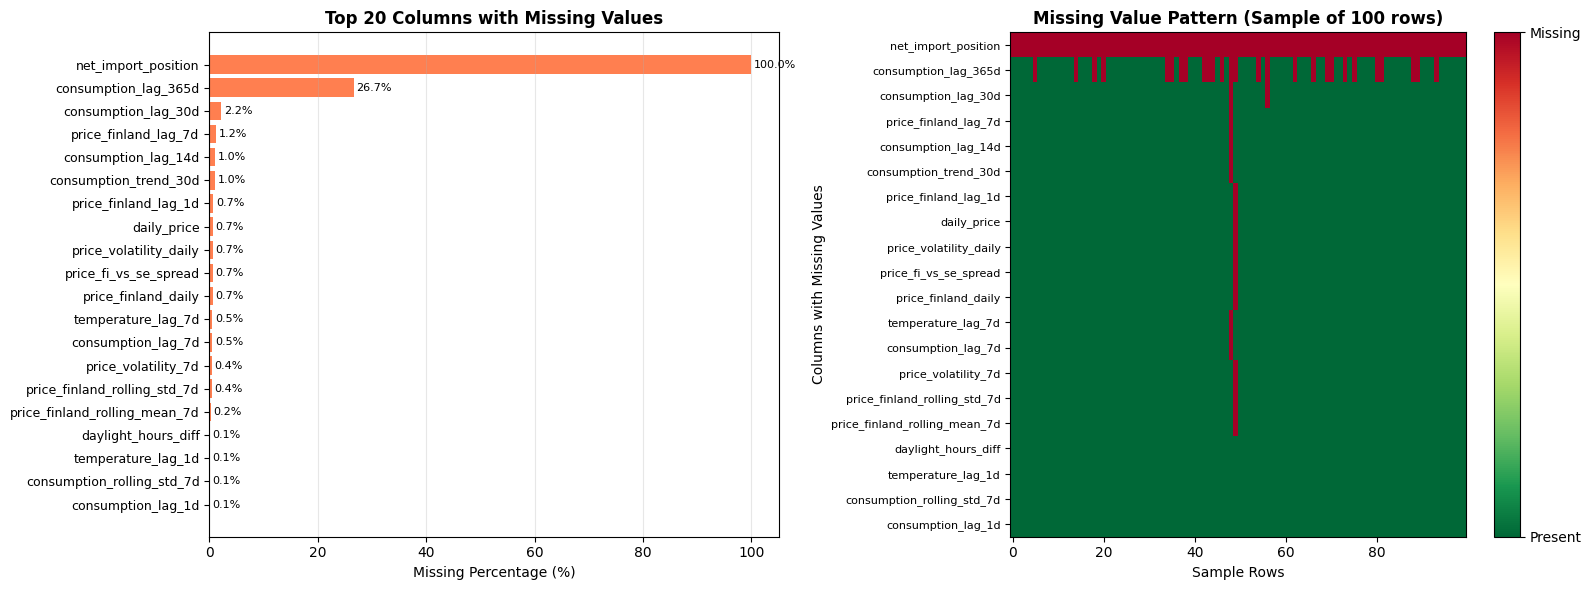


📊 Visualization saved as 'missing_values_analysis.png'



In [31]:
def check_missing_values(df, show_plot=True):
    """
    Comprehensive missing value analysis for the dataset
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to analyze
    show_plot : bool
        Whether to display visualization of missing values
    
    Returns:
    --------
    pandas.DataFrame
        Summary of missing values by column
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    print("🔍 MISSING VALUES ANALYSIS")
    print("=" * 70)
    
    # Calculate missing values
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    
    # Create summary dataframe
    missing_summary = pd.DataFrame({
        'Column': missing_count.index,
        'Missing_Count': missing_count.values,
        'Missing_Percent': missing_percent.values,
        'Data_Type': df.dtypes.values
    })
    
    # Sort by missing percentage
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values(
        'Missing_Percent', ascending=False
    ).reset_index(drop=True)
    
    # Print overall statistics
    total_cells = df.shape[0] * df.shape[1]
    total_missing = missing_count.sum()
    
    print(f"\n📊 Overall Statistics:")
    print(f"  • Total rows: {df.shape[0]:,}")
    print(f"  • Total columns: {df.shape[1]}")
    print(f"  • Total cells: {total_cells:,}")
    print(f"  • Total missing cells: {total_missing:,}")
    print(f"  • Overall missing %: {(total_missing/total_cells)*100:.2f}%")
    
    # Print columns with missing values
    if len(missing_summary) > 0:
        print(f"\n⚠️  Columns with missing values: {len(missing_summary)}")
        print("\nTop 20 columns with most missing values:")
        print("-" * 70)
        for idx, row in missing_summary.head(20).iterrows():
            print(f"{idx+1:2d}. {row['Column']:40s} | {row['Missing_Count']:8,} ({row['Missing_Percent']:6.2f}%) | {row['Data_Type']}")
    else:
        print("\n✅ No missing values found!")
    
    # Categorize columns by missing percentage
    if len(missing_summary) > 0:
        print("\n📈 Missing Value Categories:")
        critical = missing_summary[missing_summary['Missing_Percent'] > 50]
        high = missing_summary[(missing_summary['Missing_Percent'] > 20) & (missing_summary['Missing_Percent'] <= 50)]
        medium = missing_summary[(missing_summary['Missing_Percent'] > 5) & (missing_summary['Missing_Percent'] <= 20)]
        low = missing_summary[missing_summary['Missing_Percent'] <= 5]
        
        print(f"  🔴 Critical (>50%): {len(critical)} columns")
        if len(critical) > 0:
            print(f"      {', '.join(critical['Column'].head(10).tolist())}")
        
        print(f"  🟠 High (20-50%): {len(high)} columns")
        if len(high) > 0:
            print(f"      {', '.join(high['Column'].head(10).tolist())}")
        
        print(f"  🟡 Medium (5-20%): {len(medium)} columns")
        if len(medium) > 0:
            print(f"      {', '.join(medium['Column'].head(10).tolist())}")
        
        print(f"  🟢 Low (<5%): {len(low)} columns")
        if len(low) > 0:
            print(f"      {', '.join(low['Column'].head(10).tolist())}")
    
    # Visualization
    if show_plot and len(missing_summary) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Bar chart of top 20 columns with missing values
        top_20 = missing_summary.head(20)
        axes[0].barh(range(len(top_20)), top_20['Missing_Percent'], color='coral')
        axes[0].set_yticks(range(len(top_20)))
        axes[0].set_yticklabels(top_20['Column'], fontsize=9)
        axes[0].set_xlabel('Missing Percentage (%)', fontsize=10)
        axes[0].set_title('Top 20 Columns with Missing Values', fontsize=12, fontweight='bold')
        axes[0].grid(axis='x', alpha=0.3)
        axes[0].invert_yaxis()
        
        # Add percentage labels
        for i, v in enumerate(top_20['Missing_Percent']):
            axes[0].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=8)
        
        # Plot 2: Heatmap-style visualization (sample rows)
        sample_size = min(100, len(df))
        sample_df = df.sample(n=sample_size, random_state=42)
        missing_cols = missing_summary['Column'].head(30).tolist()
        
        if len(missing_cols) > 0:
            sample_missing = sample_df[missing_cols].isnull().astype(int)
            im = axes[1].imshow(sample_missing.T, cmap='RdYlGn_r', aspect='auto', interpolation='nearest')
            axes[1].set_xlabel('Sample Rows', fontsize=10)
            axes[1].set_ylabel('Columns with Missing Values', fontsize=10)
            axes[1].set_title(f'Missing Value Pattern (Sample of {sample_size} rows)', 
                            fontsize=12, fontweight='bold')
            axes[1].set_yticks(range(len(missing_cols)))
            axes[1].set_yticklabels(missing_cols, fontsize=8)
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=axes[1])
            cbar.set_ticks([0, 1])
            cbar.set_ticklabels(['Present', 'Missing'])
        
        plt.tight_layout()
        plt.savefig('missing_values_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n📊 Visualization saved as 'missing_values_analysis.png'")
    
    print("\n" + "=" * 70)
    
    return missing_summary


# Usage example:
missing_report = check_missing_values(df_enriched, show_plot=True)

# To save the report:
# missing_report.to_csv('missing_values_report.csv', index=False)

In [32]:
def handle_missing_values_window(df, drop_threshold=50, window_days=5):
    """
    Handle missing values by dropping columns with high missingness 
    and imputing the rest using rolling window median
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to clean
    drop_threshold : float
        Percentage threshold above which columns are dropped (default: 50%)
    window_days : int
        Number of days before and after to use for rolling median (default: 5)
    
    Returns:
    --------
    pandas.DataFrame
        Cleaned dataframe
    dict
        Summary of actions taken
    """
    import pandas as pd
    import numpy as np
    
    print("🔧 HANDLING MISSING VALUES WITH ROLLING WINDOW MEDIAN")
    print("=" * 70)
    
    df_cleaned = df.copy()
    
    # Ensure we have a datetime column for proper sorting
    if 'datetime' in df_cleaned.columns:
        df_cleaned = df_cleaned.sort_values('datetime').reset_index(drop=True)
    elif 'date' in df_cleaned.columns:
        df_cleaned = df_cleaned.sort_values('date').reset_index(drop=True)
    
    # Calculate missing percentages
    missing_percent = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100
    missing_cols = missing_percent[missing_percent > 0].sort_values(ascending=False)
    
    # Track actions
    actions = {
        'dropped_columns': [],
        'imputed_columns': [],
        'original_shape': df.shape,
        'final_shape': None
    }
    
    # Step 1: Identify top 2 columns with most missing values
    if len(missing_cols) >= 2:
        top_2_missing = missing_cols.head(2)
        print(f"\n🗑️  Dropping top 2 columns with most missing values:")
        for col, pct in top_2_missing.items():
            print(f"  ✗ {col}: {pct:.2f}% missing")
            df_cleaned = df_cleaned.drop(columns=[col])
            actions['dropped_columns'].append((col, pct))
    
    # Step 2: Impute remaining columns using rolling window median
    remaining_missing = df_cleaned.isnull().sum()
    cols_to_impute = remaining_missing[remaining_missing > 0].index.tolist()
    
    if len(cols_to_impute) > 0:
        print(f"\n💉 Imputing {len(cols_to_impute)} columns using ±{window_days} day rolling window median:")
        
        # Group by date to handle hourly data properly
        if 'date' in df_cleaned.columns:
            # For hourly data, we need to calculate daily medians first
            for col in cols_to_impute:
                if df_cleaned[col].dtype in ['float64', 'int64']:
                    missing_count_before = df_cleaned[col].isnull().sum()
                    missing_pct = (missing_count_before / len(df_cleaned)) * 100
                    
                    # Calculate daily median for the column
                    daily_values = df_cleaned.groupby('date')[col].transform('median')
                    
                    # Create rolling window median (±window_days)
                    # Convert to daily series first
                    daily_series = df_cleaned.groupby('date')[col].median()
                    
                    # Calculate rolling median with center=True for ±window_days
                    window_size = 2 * window_days + 1  # Total window: before + current + after
                    rolling_median = daily_series.rolling(
                        window=window_size, 
                        center=True, 
                        min_periods=1
                    ).median()
                    
                    # Map back to hourly data
                    date_to_median = rolling_median.to_dict()
                    df_cleaned[col] = df_cleaned.apply(
                        lambda row: date_to_median.get(row['date'], row[col]) 
                        if pd.isna(row[col]) else row[col], 
                        axis=1
                    )
                    
                    # If still NaN (edge cases), use forward/backward fill
                    if df_cleaned[col].isnull().sum() > 0:
                        df_cleaned[col] = df_cleaned[col].fillna(method='ffill').fillna(method='bfill')
                    
                    missing_count_after = df_cleaned[col].isnull().sum()
                    filled_count = missing_count_before - missing_count_after
                    
                    print(f"  ✓ {col}: {missing_count_before:,} ({missing_pct:.2f}%) → filled {filled_count:,} values")
                    actions['imputed_columns'].append((col, missing_count_before, missing_pct, f'±{window_days}d rolling median'))
                
                else:
                    # For non-numeric columns, use forward fill then backward fill
                    missing_count = df_cleaned[col].isnull().sum()
                    missing_pct = (missing_count / len(df_cleaned)) * 100
                    df_cleaned[col] = df_cleaned[col].fillna(method='ffill').fillna(method='bfill')
                    print(f"  ✓ {col}: {missing_count:,} ({missing_pct:.2f}%) → filled with forward/backward fill")
                    actions['imputed_columns'].append((col, missing_count, missing_pct, 'ffill/bfill'))
        else:
            # If no date column, fall back to simple rolling window on index
            print("  ⚠️  No 'date' column found, using index-based rolling window")
            for col in cols_to_impute:
                if df_cleaned[col].dtype in ['float64', 'int64']:
                    missing_count_before = df_cleaned[col].isnull().sum()
                    missing_pct = (missing_count_before / len(df_cleaned)) * 100
                    
                    # Simple rolling median
                    window_size = 2 * window_days + 1
                    rolling_median = df_cleaned[col].rolling(
                        window=window_size,
                        center=True,
                        min_periods=1
                    ).median()
                    
                    # Fill NaN values
                    df_cleaned[col] = df_cleaned[col].fillna(rolling_median)
                    
                    # If still NaN, use forward/backward fill
                    if df_cleaned[col].isnull().sum() > 0:
                        df_cleaned[col] = df_cleaned[col].fillna(method='ffill').fillna(method='bfill')
                    
                    missing_count_after = df_cleaned[col].isnull().sum()
                    filled_count = missing_count_before - missing_count_after
                    
                    print(f"  ✓ {col}: {missing_count_before:,} ({missing_pct:.2f}%) → filled {filled_count:,} values")
                    actions['imputed_columns'].append((col, missing_count_before, missing_pct, f'{window_size}-row rolling median'))
    
    actions['final_shape'] = df_cleaned.shape
    
    # Final verification
    final_missing = df_cleaned.isnull().sum().sum()
    
    print(f"\n📊 Summary:")
    print(f"  • Original shape: {actions['original_shape']}")
    print(f"  • Columns dropped: {len(actions['dropped_columns'])}")
    print(f"  • Columns imputed: {len(actions['imputed_columns'])}")
    print(f"  • Final shape: {actions['final_shape']}")
    print(f"  • Window size: ±{window_days} days")
    print(f"  • Remaining missing values: {final_missing:,}")
    
    if final_missing == 0:
        print(f"\n✅ SUCCESS: No missing values remain!")
    else:
        print(f"\n⚠️  WARNING: {final_missing:,} missing values still present")
        print(f"\nColumns still with missing values:")
        still_missing = df_cleaned.isnull().sum()
        for col, count in still_missing[still_missing > 0].items():
            print(f"  • {col}: {count:,}")
    
    print("=" * 70)
    
    return df_cleaned, actions


# Usage:
df_cleaned, cleaning_summary = handle_missing_values_window(
    df_enriched, 
    window_days=5  # Use 5 days before and 5 days after
)

# Verify no missing values
print("\n🔍 Final verification:")
missing_by_col = df_cleaned.isnull().sum()
print(f"Total missing values: {missing_by_col.sum()}")
if missing_by_col.sum() > 0:
    print("\nColumns with remaining missing values:")
    print(missing_by_col[missing_by_col > 0])

# Save cleaned dataset
df_cleaned.to_csv('energy_data_cleaned.csv', index=False)
print("\n💾 Cleaned dataset saved as 'energy_data_cleaned.csv'")

🔧 HANDLING MISSING VALUES WITH ROLLING WINDOW MEDIAN

🗑️  Dropping top 2 columns with most missing values:
  ✗ net_import_position: 100.00% missing
  ✗ consumption_lag_365d: 26.66% missing

💉 Imputing 18 columns using ±5 day rolling window median:
  ✓ daily_price: 24,192 (0.66%) → filled 24,192 values
  ✓ price_finland_daily: 24,192 (0.66%) → filled 24,192 values
  ✓ consumption_lag_1d: 2,688 (0.07%) → filled 2,688 values
  ✓ consumption_lag_7d: 18,816 (0.51%) → filled 18,816 values
  ✓ consumption_lag_14d: 37,632 (1.02%) → filled 37,632 values
  ✓ consumption_lag_30d: 80,640 (2.19%) → filled 80,640 values
  ✓ consumption_rolling_std_7d: 2,688 (0.07%) → filled 2,688 values
  ✓ price_finland_lag_1d: 26,880 (0.73%) → filled 26,880 values
  ✓ price_finland_lag_7d: 43,008 (1.17%) → filled 43,008 values
  ✓ price_finland_rolling_mean_7d: 8,064 (0.22%) → filled 8,064 values
  ✓ price_finland_rolling_std_7d: 16,128 (0.44%) → filled 16,128 values
  ✓ temperature_lag_1d: 2,688 (0.07%) → filled 

In [33]:
df_cleaned["date"].tail()

3679867   2024-09-30
3679868   2024-09-30
3679869   2024-09-30
3679870   2024-09-30
3679871   2024-09-30
Name: date, dtype: datetime64[ns]

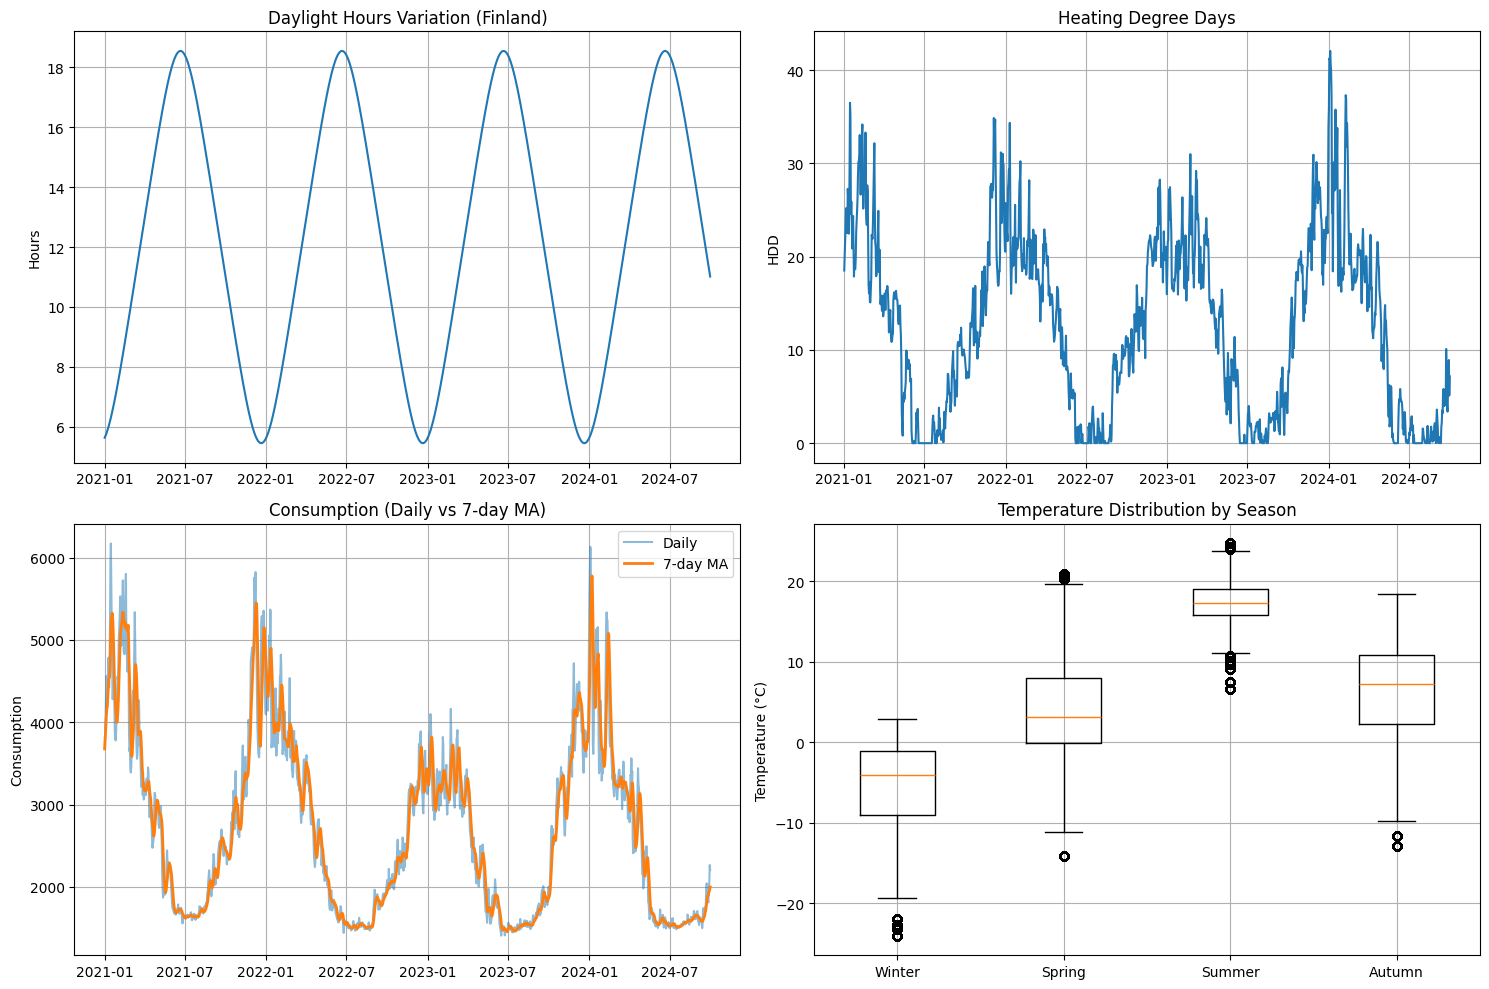


📊 Feature visualizations saved as 'feature_visualization.png'


In [97]:
# Quick visualization of key features
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Daylight hours variation
daily_summary = df_enriched.groupby('date').first()
axes[0, 0].plot(daily_summary.index, daily_summary['daylight_hours'])
axes[0, 0].set_title('Daylight Hours Variation (Finland)')
axes[0, 0].set_ylabel('Hours')
axes[0, 0].grid(True)

# Plot 2: Heating Degree Days
axes[0, 1].plot(daily_summary.index, daily_summary['heating_degree_days'])
axes[0, 1].set_title('Heating Degree Days')
axes[0, 1].set_ylabel('HDD')
axes[0, 1].grid(True)

# Plot 3: Consumption with 7-day rolling mean
axes[1, 0].plot(daily_summary.index, daily_summary['consumption_daily'], alpha=0.5, label='Daily')
axes[1, 0].plot(daily_summary.index, daily_summary['consumption_rolling_mean_7d'], linewidth=2, label='7-day MA')
axes[1, 0].set_title('Consumption (Daily vs 7-day MA)')
axes[1, 0].set_ylabel('Consumption')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Temperature distribution by season
season_temps = df_enriched.groupby('season')['temperature_mean_daily'].apply(list)
axes[1, 1].boxplot([season_temps[i] for i in range(4)], labels=['Winter', 'Spring', 'Summer', 'Autumn'])
axes[1, 1].set_title('Temperature Distribution by Season')
axes[1, 1].set_ylabel('Temperature (°C)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('feature_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Feature visualizations saved as 'feature_visualization.png'")

🔍 Analyzing feature correlations with consumption...

Top 20 features correlated with hourly consumption:
hourly_consumption              1.000000
daily_consumption               0.985022
consumption_daily               0.252135
consumption_lag_1d              0.248641
consumption_vs_yearly_avg       0.246554
consumption_rolling_mean_7d     0.244029
consumption_rolling_min_7d      0.243893
consumption_rolling_max_7d      0.242492
heating_degree_days             0.240816
temperature_mean_daily          0.238790
temperature_lag_1d              0.237958
temperature_rolling_mean_7d     0.234648
temperature_min_daily           0.232633
consumption_rolling_mean_30d    0.232185
temp                            0.228302
dwpt                            0.226863
consumption_lag_7d              0.224311
fourier_annual_cos_1            0.216874
day_of_year_cos                 0.216874
consumption_lag_14d             0.216862
Name: hourly_consumption, dtype: float64


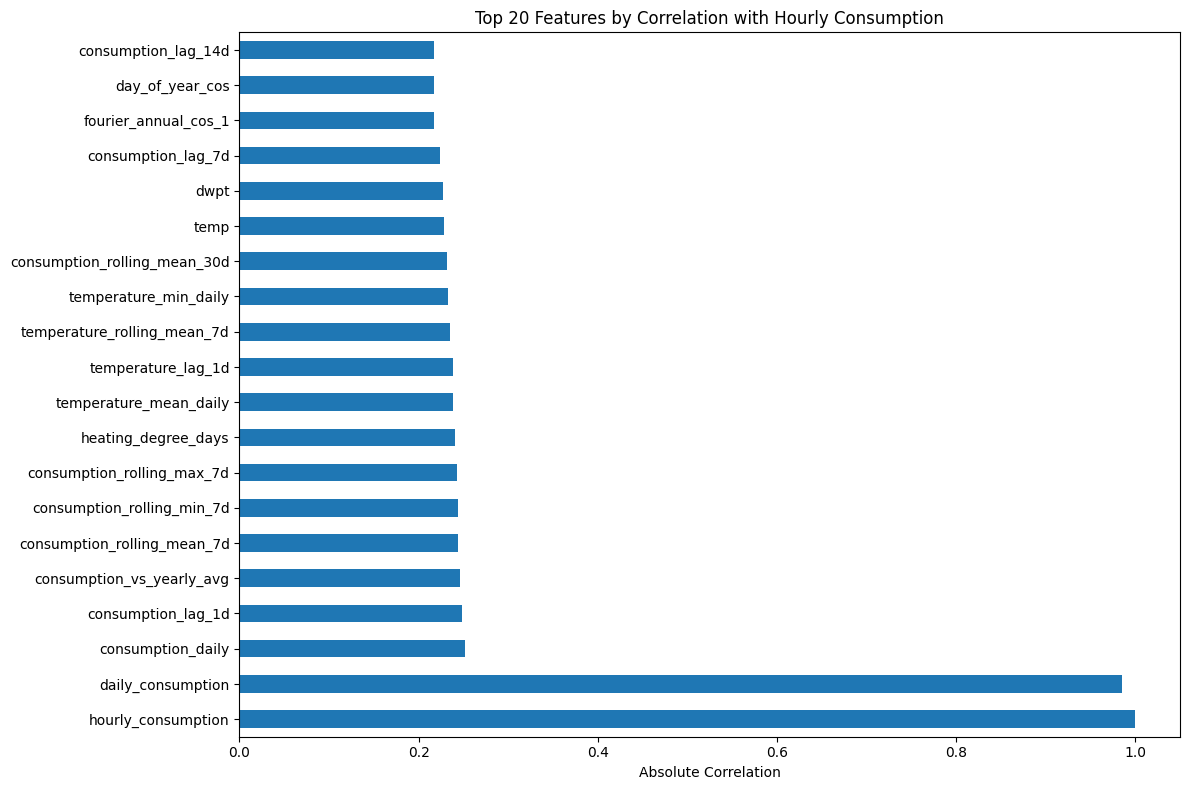


📊 Correlation plot saved as 'feature_correlations.png'


In [98]:
# Feature correlation analysis
print("🔍 Analyzing feature correlations with consumption...\n")

# Select numerical features
numerical_cols = df_enriched.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlations with consumption
correlations = df_enriched[numerical_cols].corr()['hourly_consumption'].abs().sort_values(ascending=False)

print("Top 20 features correlated with hourly consumption:")
print(correlations.head(20))

# Visualize top correlations
plt.figure(figsize=(12, 8))
correlations.head(20).plot(kind='barh')
plt.title('Top 20 Features by Correlation with Hourly Consumption')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Correlation plot saved as 'feature_correlations.png'")

🚫 REMOVING OVERFITTING FEATURES

🗑️  Removing overfitting features:
  ✗ daily_consumption

🗑️  Removing redundant features:
  ✗ daily_price

✓ Removed 2 overfitting/redundant features
  Remaining features: 107

📊 CHI-SQUARED FEATURE SELECTION

📋 Valid numeric features for Chi² test: 94
  ✓ Scaled features to [0, 1] range
  ✓ Binned target into 10 categories

🧪 Running Chi-squared test...

✅ Chi-squared test complete!

📊 Top 20 features by Chi² score:
----------------------------------------------------------------------
✓ is_summer_vacation                       | Chi²:  147859.05 | p: 0.0000
✓ is_heating_season                        | Chi²:  137351.83 | p: 0.0000
✓ consumption_rolling_mean_30d             | Chi²:   82097.02 | p: 0.0000
✓ day_of_year_cos                          | Chi²:   81870.65 | p: 0.0000
✓ fourier_annual_cos_1                     | Chi²:   81870.65 | p: 0.0000
✓ consumption_rolling_max_7d               | Chi²:   76382.93 | p: 0.0000
✓ consumption_rolling_mean_7d 

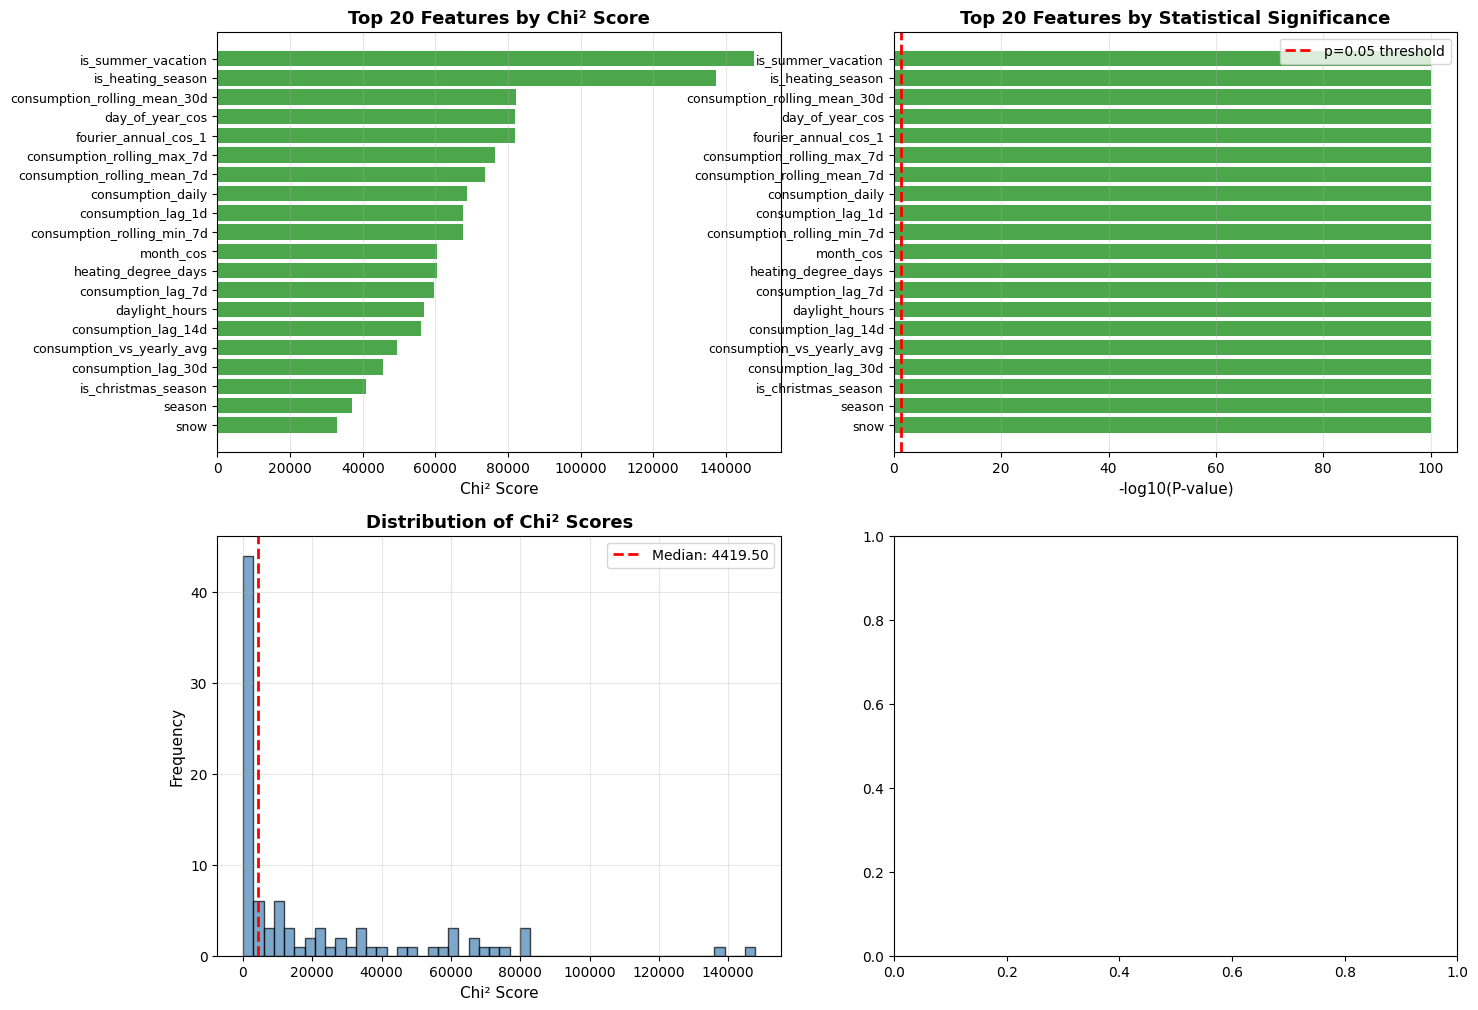

In [34]:
def remove_overfitting_features_and_chi2(df, target_col='hourly_consumption'):
    """
    Remove features that cause overfitting and perform chi-squared test
    for feature selection
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe with all features
    target_col : str
        Name of the target variable column
    
    Returns:
    --------
    pandas.DataFrame
        Cleaned dataframe without overfitting features
    dict
        Chi-squared test results and feature importance
    """
    import pandas as pd
    import numpy as np
    from sklearn.feature_selection import chi2, SelectKBest
    from sklearn.preprocessing import MinMaxScaler
    import matplotlib.pyplot as plt
    
    print("🚫 REMOVING OVERFITTING FEATURES")
    print("=" * 70)
    
    df_clean = df.copy()
    
    # ============================================================================
    # STEP 1: Remove obvious overfitting features
    # ============================================================================
    
    overfitting_features = [
        # Direct leakage - these are the target in different forms
        'daily_consumption',  # This is just hourly_consumption aggregated  
    ]
    
    # Also remove duplicate/redundant features
    redundant_features = [
        'daily_price',  # If we have price_finland_daily
    ]
    
    features_to_remove = []
    
    print("\n🗑️  Removing overfitting features:")
    for feat in overfitting_features:
        if feat in df_clean.columns and feat != target_col:
            features_to_remove.append(feat)
            print(f"  ✗ {feat}")
    
    print("\n🗑️  Removing redundant features:")
    for feat in redundant_features:
        if feat in df_clean.columns:
            features_to_remove.append(feat)
            print(f"  ✗ {feat}")
    
    # Remove the features
    df_clean = df_clean.drop(columns=features_to_remove, errors='ignore')
    
    print(f"\n✓ Removed {len(features_to_remove)} overfitting/redundant features")
    print(f"  Remaining features: {len(df_clean.columns)}")
    
    # ============================================================================
    # STEP 2: Prepare data for Chi-squared test
    # ============================================================================
    
    print("\n" + "=" * 70)
    print("📊 CHI-SQUARED FEATURE SELECTION")
    print("=" * 70)
    
    # Separate features and target
    if target_col not in df_clean.columns:
        print(f"\n❌ Error: Target column '{target_col}' not found!")
        return df_clean, {}
    
    # Get only numeric columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove target from features
    feature_cols = [col for col in numeric_cols if col != target_col]
    
    # Remove any columns with all NaN or constant values
    valid_features = []
    for col in feature_cols:
        if df_clean[col].notna().sum() > 0 and df_clean[col].std() > 0:
            valid_features.append(col)
    
    print(f"\n📋 Valid numeric features for Chi² test: {len(valid_features)}")
    
    # Prepare X and y
    X = df_clean[valid_features].fillna(0)  # Fill any remaining NaN with 0
    y = df_clean[target_col].fillna(0)
    
    # Chi-squared requires non-negative values, so we'll use MinMaxScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=valid_features)
    
    # Also scale y to be non-negative
    y_scaled = (y - y.min()) / (y.max() - y.min()) if y.max() != y.min() else y
    
    # Discretize y for chi-squared (create bins)
    y_binned = pd.qcut(y_scaled, q=10, labels=False, duplicates='drop')
    
    print(f"  ✓ Scaled features to [0, 1] range")
    print(f"  ✓ Binned target into {len(np.unique(y_binned))} categories")
    
    # ============================================================================
    # STEP 3: Perform Chi-squared test
    # ============================================================================
    
    print("\n🧪 Running Chi-squared test...")
    
    try:
        chi2_scores, p_values = chi2(X_scaled, y_binned)
        
        # Create results dataframe
        chi2_results = pd.DataFrame({
            'Feature': valid_features,
            'Chi2_Score': chi2_scores,
            'P_Value': p_values,
            'Significant': p_values < 0.05
        }).sort_values('Chi2_Score', ascending=False)
        
        print("\n✅ Chi-squared test complete!")
        print(f"\n📊 Top 20 features by Chi² score:")
        print("-" * 70)
        for idx, row in chi2_results.head(20).iterrows():
            sig = "✓" if row['Significant'] else "✗"
            print(f"{sig} {row['Feature']:40s} | Chi²: {row['Chi2_Score']:10.2f} | p: {row['P_Value']:.4f}")
        
        # Summary statistics
        significant_features = chi2_results[chi2_results['Significant']]
        print(f"\n📈 Summary:")
        print(f"  • Total features tested: {len(chi2_results)}")
        print(f"  • Significant features (p < 0.05): {len(significant_features)}")
        print(f"  • Non-significant features: {len(chi2_results) - len(significant_features)}")
        
        # ====================================================================
        # STEP 4: Visualize results
        # ====================================================================
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: Top 20 Chi² scores
        top_20 = chi2_results.head(20)
        colors = ['green' if sig else 'red' for sig in top_20['Significant']]
        axes[0, 0].barh(range(len(top_20)), top_20['Chi2_Score'], color=colors, alpha=0.7)
        axes[0, 0].set_yticks(range(len(top_20)))
        axes[0, 0].set_yticklabels(top_20['Feature'], fontsize=9)
        axes[0, 0].set_xlabel('Chi² Score', fontsize=11)
        axes[0, 0].set_title('Top 20 Features by Chi² Score', fontsize=13, fontweight='bold')
        axes[0, 0].invert_yaxis()
        axes[0, 0].grid(axis='x', alpha=0.3)
        
        # Plot 2: P-values (log scale)
        axes[0, 1].barh(range(len(top_20)), -np.log10(top_20['P_Value'] + 1e-100), color=colors, alpha=0.7)
        axes[0, 1].set_yticks(range(len(top_20)))
        axes[0, 1].set_yticklabels(top_20['Feature'], fontsize=9)
        axes[0, 1].set_xlabel('-log10(P-value)', fontsize=11)
        axes[0, 1].set_title('Top 20 Features by Statistical Significance', fontsize=13, fontweight='bold')
        axes[0, 1].axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05 threshold')
        axes[0, 1].invert_yaxis()
        axes[0, 1].legend()
        axes[0, 1].grid(axis='x', alpha=0.3)
        
        # Plot 3: Chi² score distribution
        axes[1, 0].hist(chi2_results['Chi2_Score'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Chi² Score', fontsize=11)
        axes[1, 0].set_ylabel('Frequency', fontsize=11)
        axes[1, 0].set_title('Distribution of Chi² Scores', fontsize=13, fontweight='bold')
        axes[1, 0].axvline(x=chi2_results['Chi2_Score'].median(), color='red', 
                          linestyle='--', linewidth=2, label=f'Median: {chi2_results["Chi2_Score"].median():.2f}')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
        
        # Plot 4: Significant vs Non-significant
        sig_counts = chi2_results['Significant'].value_counts()
        axes[1, 1].pie(sig_counts, labels=['Significant (p<0.05)', 'Non-significant'],
                      colors=['green', 'red'], autopct='%1.1f%%', startangle=90, alpha=0.7)
        axes[1, 1].set_title('Feature Significance Distribution', fontsize=13, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('chi2_feature_selection.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n📊 Visualizations saved as 'chi2_feature_selection.png'")
        
        # ====================================================================
        # STEP 5: Save results
        # ====================================================================
        
        chi2_results.to_csv('chi2_feature_scores.csv', index=False)
        print("💾 Chi² scores saved as 'chi2_feature_scores.csv'")
        
        results_dict = {
            'chi2_results': chi2_results,
            'removed_features': features_to_remove,
            'significant_features': significant_features['Feature'].tolist(),
            'top_20_features': top_20['Feature'].tolist()
        }
        
    except Exception as e:
        print(f"\n❌ Error during Chi² test: {str(e)}")
        results_dict = {
            'chi2_results': None,
            'removed_features': features_to_remove,
            'error': str(e)
        }
    
    print("\n" + "=" * 70)
    print("✅ FEATURE CLEANING AND SELECTION COMPLETE")
    print("=" * 70)
    
    return df_clean, results_dict


# Usage:
df_no_overfit, chi2_results = remove_overfitting_features_and_chi2(df_cleaned)

# Save the cleaned dataset without overfitting features
df_no_overfit.to_csv('energy_data_no_overfit.csv', index=False)
print("\n💾 Dataset without overfitting features saved as 'energy_data_no_overfit.csv'")

# Print top features for modeling
if 'top_20_features' in chi2_results:
    print("\n🎯 RECOMMENDED TOP 20 FEATURES FOR MODELING:")
    for i, feat in enumerate(chi2_results['top_20_features'], 1):
        print(f"  {i:2d}. {feat}")

In [104]:
# ============================================================================
# INSTALL REQUIRED PACKAGES
# ============================================================================

import subprocess
import sys

print("📦 Installing required packages...")

packages = ['lightgbm', 'xgboost']

for package in packages:
    try:
        __import__(package)
        print(f"  ✓ {package} already installed")
    except ImportError:
        print(f"  📥 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"  ✓ {package} installed successfully")

print("\n✅ All packages ready!\n")

# ============================================================================
# FORTUM JUNCTION 2025 - ENERGY FORECASTING MODELS
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("🚀 FORTUM ENERGY FORECASTING - MODEL TRAINING PIPELINE")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'n_splits': 5,
    'forecast_horizon_hours': 48,
    'forecast_horizon_months': 12,
    'cutoff_date': '2024-09-30 23:00:00',
    'forecast_start_hourly': '2024-10-01 00:00:00',
    'forecast_start_monthly': '2024-10-01',
    'random_state': 42
}

# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================

print("\n📂 Loading cleaned dataset...")
df = pd.read_csv('energy_data_no_overfit.csv')

print(f"\n📋 Sample of available columns:")
print(df.columns.tolist()[:20])

# Reconstruct datetime from year, month, day_of_month, hour
print("\n🔧 Reconstructing datetime from year, month, day_of_month, hour...")

if 'year' in df.columns and 'month' in df.columns and 'day_of_month' in df.columns and 'hour' in df.columns:
    # Create datetime
    df['datetime'] = pd.to_datetime(
        df['year'].astype(str) + '-' + 
        df['month'].astype(str).str.zfill(2) + '-' + 
        df['day_of_month'].astype(str).str.zfill(2) + ' ' + 
        df['hour'].astype(str).str.zfill(2) + ':00:00'
    )
    print("  ✓ Datetime column created successfully")
else:
    raise ValueError("Missing required columns: year, month, day_of_month, or hour")

df = df.sort_values('datetime').reset_index(drop=True)

print(f"  ✓ Loaded {len(df):,} rows")
print(f"  ✓ Date range: {df['datetime'].min()} to {df['datetime'].max()}")

# ============================================================================
# STEP 2: DEFINE FEATURES FOR DIFFERENT MODELS
# ============================================================================

print("\n🎯 Defining feature sets for models...")

# Features that should NOT be used (overfitting/leakage)
EXCLUDE_FEATURES = [
    'datetime', 'date', 'hour', 'group_id',
    'daily_consumption', 'consumption_daily',
    'consumption_lag_1d',
    'consumption_rolling_mean_7d', 'consumption_rolling_std_7d',
    'consumption_rolling_min_7d', 'consumption_rolling_max_7d',
    'consumption_rolling_mean_30d', 'consumption_vs_yearly_avg',
    'consumption_trend_30d',
    # Text columns
    'region', 'province', 'city', 'customer_type', 
    'pricing_type', 'pricing_level',
    'net_import_export', 'production'
]

# Get all numeric columns
all_numeric = df.select_dtypes(include=[np.number]).columns.tolist()

# Features for HOURLY consumption model
HOURLY_CONSUMPTION_FEATURES = [
    col for col in all_numeric 
    if col not in EXCLUDE_FEATURES 
    and col != 'hourly_consumption'
]

# Features for MONTHLY models
MONTHLY_FEATURES = [
    col for col in all_numeric
    if col not in EXCLUDE_FEATURES
    and col != 'hourly_consumption'
]

print(f"  ✓ Hourly consumption features: {len(HOURLY_CONSUMPTION_FEATURES)}")
print(f"  ✓ Monthly features: {len(MONTHLY_FEATURES)}")

print(f"\n  Sample features:")
for feat in HOURLY_CONSUMPTION_FEATURES[:15]:
    print(f"    • {feat}")

# ============================================================================
# STEP 3: PREPARE TRAINING DATA WITH TIME-BASED SPLIT
# ============================================================================

print("\n📊 Preparing training/validation split...")

cutoff_datetime = pd.to_datetime(CONFIG['cutoff_date'])
train_hourly = df[df['datetime'] <= cutoff_datetime].copy()

print(f"  ✓ Training data: {len(train_hourly):,} hourly records")
print(f"  ✓ Training period: {train_hourly['datetime'].min()} to {train_hourly['datetime'].max()}")

# For monthly aggregation
print("\n📅 Aggregating to monthly data...")
train_hourly['year_month'] = train_hourly['datetime'].dt.to_period('M')

agg_dict = {'hourly_consumption': 'sum'}

for feat in MONTHLY_FEATURES:
    if feat in train_hourly.columns:
        agg_dict[feat] = 'mean'

monthly_agg = train_hourly.groupby('year_month').agg(agg_dict).reset_index()
monthly_agg['year_month'] = monthly_agg['year_month'].astype(str)
monthly_agg['date'] = pd.to_datetime(monthly_agg['year_month'] + '-01')

print(f"  ✓ Monthly data: {len(monthly_agg)} months")
print(f"  ✓ Monthly period: {monthly_agg['date'].min()} to {monthly_agg['date'].max()}")

# ============================================================================
# STEP 4: TIME SERIES CROSS-VALIDATION SETUP
# ============================================================================

print("\n🔄 Setting up Time Series Cross-Validation...")

def create_time_series_splits(df, n_splits=5, test_size_days=14, gap_days=1):
    """Create time series splits with a gap to prevent leakage"""
    splits = []
    test_size_hours = test_size_days * 24
    gap_hours = gap_days * 24
    
    for i in range(n_splits):
        test_end_offset = i * (test_size_days // 2) * 24
        test_end_idx = len(df) - test_end_offset - 1
        test_start_idx = max(0, test_end_idx - test_size_hours)
        
        train_end_idx = test_start_idx - gap_hours
        
        if train_end_idx > len(df) * 0.3:
            train_indices = np.arange(0, train_end_idx)
            test_indices = np.arange(test_start_idx, test_end_idx)
            
            splits.append((train_indices, test_indices))
    
    return splits[::-1]

hourly_splits = create_time_series_splits(train_hourly, n_splits=CONFIG['n_splits'])

print(f"  ✓ Created {len(hourly_splits)} time series folds")
for i, (train_idx, test_idx) in enumerate(hourly_splits):
    train_dates = train_hourly.iloc[train_idx]['datetime']
    test_dates = train_hourly.iloc[test_idx]['datetime']
    print(f"    Fold {i+1}: Train {len(train_idx):,} | Test {len(test_idx):,}")

tscv_monthly = TimeSeriesSplit(n_splits=min(CONFIG['n_splits'], len(monthly_agg) - 12))

# ============================================================================
# STEP 5: MODEL TRAINING - 48 HOUR CONSUMPTION FORECAST
# ============================================================================

print("\n" + "=" * 80)
print("🎯 MODEL 1: 48-HOUR CONSUMPTION FORECAST")
print("=" * 80)

X_hourly_consumption = train_hourly[HOURLY_CONSUMPTION_FEATURES].fillna(0)
y_hourly_consumption = train_hourly['hourly_consumption']

models_48h_consumption = {
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=8,
        num_leaves=31,
        random_state=CONFIG['random_state'],
        verbose=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=8,
        random_state=CONFIG['random_state'],
        verbosity=0
    ),
    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        random_state=CONFIG['random_state'],
        n_jobs=-1
    )
}

cv_results_48h_consumption = {}

for model_name, model in models_48h_consumption.items():
    print(f"\n🔧 Training {model_name}...")
    
    fold_scores = {'mae': [], 'rmse': [], 'mape': []}
    
    for fold, (train_idx, test_idx) in enumerate(hourly_splits, 1):
        X_train = X_hourly_consumption.iloc[train_idx]
        y_train = y_hourly_consumption.iloc[train_idx]
        X_test = X_hourly_consumption.iloc[test_idx]
        y_test = y_hourly_consumption.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        
        fold_scores['mae'].append(mae)
        fold_scores['rmse'].append(rmse)
        fold_scores['mape'].append(mape)
        
        print(f"  Fold {fold}: MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.2f}%")
    
    cv_results_48h_consumption[model_name] = {
        'mae_mean': np.mean(fold_scores['mae']),
        'mae_std': np.std(fold_scores['mae']),
        'rmse_mean': np.mean(fold_scores['rmse']),
        'rmse_std': np.std(fold_scores['rmse']),
        'mape_mean': np.mean(fold_scores['mape']),
        'mape_std': np.std(fold_scores['mape'])
    }
    
    print(f"\n  📊 {model_name} CV Results:")
    print(f"    MAE:  {cv_results_48h_consumption[model_name]['mae_mean']:.4f} ± {cv_results_48h_consumption[model_name]['mae_std']:.4f}")
    print(f"    RMSE: {cv_results_48h_consumption[model_name]['rmse_mean']:.4f} ± {cv_results_48h_consumption[model_name]['rmse_std']:.4f}")
    print(f"    MAPE: {cv_results_48h_consumption[model_name]['mape_mean']:.2f}% ± {cv_results_48h_consumption[model_name]['mape_std']:.2f}%")

best_model_48h_consumption = min(cv_results_48h_consumption, 
                                  key=lambda x: cv_results_48h_consumption[x]['mape_mean'])
print(f"\n✅ Best model for 48h consumption: {best_model_48h_consumption}")

final_model_48h_consumption = models_48h_consumption[best_model_48h_consumption]
final_model_48h_consumption.fit(X_hourly_consumption, y_hourly_consumption)

# ============================================================================
# STEP 6: MODEL TRAINING - 12 MONTH CONSUMPTION FORECAST
# ============================================================================

print("\n" + "=" * 80)
print("📅 MODEL 2: 12-MONTH CONSUMPTION FORECAST")
print("=" * 80)

valid_monthly_features = [f for f in MONTHLY_FEATURES if f in monthly_agg.columns]
X_monthly_consumption = monthly_agg[valid_monthly_features].fillna(0)
y_monthly_consumption = monthly_agg['hourly_consumption']

models_12m_consumption = {
    'LightGBM': LGBMRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=20,
        random_state=CONFIG['random_state'],
        verbose=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=6,
        random_state=CONFIG['random_state'],
        verbosity=0
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=6,
        random_state=CONFIG['random_state']
    )
}

cv_results_12m_consumption = {}

for model_name, model in models_12m_consumption.items():
    print(f"\n🔧 Training {model_name}...")
    
    fold_scores = {'mae': [], 'rmse': [], 'mape': []}
    
    for fold, (train_idx, test_idx) in enumerate(tscv_monthly.split(X_monthly_consumption), 1):
        X_train = X_monthly_consumption.iloc[train_idx]
        y_train = y_monthly_consumption.iloc[train_idx]
        X_test = X_monthly_consumption.iloc[test_idx]
        y_test = y_monthly_consumption.iloc[test_idx]
        
        if len(X_train) < 12:
            continue
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        
        fold_scores['mae'].append(mae)
        fold_scores['rmse'].append(rmse)
        fold_scores['mape'].append(mape)
        
        print(f"  Fold {fold}: MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.2f}%")
    
    if len(fold_scores['mae']) > 0:
        cv_results_12m_consumption[model_name] = {
            'mae_mean': np.mean(fold_scores['mae']),
            'mae_std': np.std(fold_scores['mae']),
            'rmse_mean': np.mean(fold_scores['rmse']),
            'rmse_std': np.std(fold_scores['rmse']),
            'mape_mean': np.mean(fold_scores['mape']),
            'mape_std': np.std(fold_scores['mape'])
        }
        
        print(f"\n  📊 {model_name} CV Results:")
        print(f"    MAE:  {cv_results_12m_consumption[model_name]['mae_mean']:.4f} ± {cv_results_12m_consumption[model_name]['mae_std']:.4f}")
        print(f"    RMSE: {cv_results_12m_consumption[model_name]['rmse_mean']:.4f} ± {cv_results_12m_consumption[model_name]['rmse_std']:.4f}")
        print(f"    MAPE: {cv_results_12m_consumption[model_name]['mape_mean']:.2f}% ± {cv_results_12m_consumption[model_name]['mape_std']:.2f}%")

best_model_12m_consumption = min(cv_results_12m_consumption, 
                                  key=lambda x: cv_results_12m_consumption[x]['mape_mean'])
print(f"\n✅ Best model for 12m consumption: {best_model_12m_consumption}")

final_model_12m_consumption = models_12m_consumption[best_model_12m_consumption]
final_model_12m_consumption.fit(X_monthly_consumption, y_monthly_consumption)

# ============================================================================
# STEP 7: SAVE MODELS AND RESULTS
# ============================================================================

print("\n💾 Saving models and results...")

import pickle

models_to_save = {
    '48h_consumption': final_model_48h_consumption,
    '12m_consumption': final_model_12m_consumption
}

for model_name, model in models_to_save.items():
    with open(f'model_{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
    print(f"  ✓ Saved {model_name} model")

feature_lists = {
    'hourly_consumption_features': HOURLY_CONSUMPTION_FEATURES,
    'monthly_features': valid_monthly_features
}

with open('feature_lists.pkl', 'wb') as f:
    pickle.dump(feature_lists, f)
print("  ✓ Saved feature lists")

# Save CV results
cv_summary = pd.DataFrame({
    '48h_Consumption': pd.Series(cv_results_48h_consumption[best_model_48h_consumption]),
    '12m_Consumption': pd.Series(cv_results_12m_consumption[best_model_12m_consumption])
})

cv_summary.to_csv('cv_results_summary.csv')
print("  ✓ Saved CV results summary")

print("\n" + "=" * 80)
print("✅ MODEL TRAINING COMPLETE!")
print("=" * 80)

print(f"\n📊 BEST MODELS SUMMARY:")
print(f"\n  1. 48-Hour Consumption: {best_model_48h_consumption}")
print(f"     MAPE: {cv_results_48h_consumption[best_model_48h_consumption]['mape_mean']:.2f}% ± {cv_results_48h_consumption[best_model_48h_consumption]['mape_std']:.2f}%")

print(f"\n  2. 12-Month Consumption: {best_model_12m_consumption}")
print(f"     MAPE: {cv_results_12m_consumption[best_model_12m_consumption]['mape_mean']:.2f}% ± {cv_results_12m_consumption[best_model_12m_consumption]['mape_std']:.2f}%")

print("\n📁 Saved Files:")
print("  • model_48h_consumption.pkl")
print("  • model_12m_consumption.pkl")
print("  • feature_lists.pkl")
print("  • cv_results_summary.csv")

print("\n" + "=" * 80)

📦 Installing required packages...
  ✓ lightgbm already installed
  ✓ xgboost already installed

✅ All packages ready!

🚀 FORTUM ENERGY FORECASTING - MODEL TRAINING PIPELINE

📂 Loading cleaned dataset...

📋 Sample of available columns:
['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'coco', 'region', 'hour', 'group_id', 'province', 'city', 'customer_type', 'pricing_type', 'pricing_level', 'net_import_export', 'production']

🔧 Reconstructing datetime from year, month, day_of_month, hour...
  ✓ Datetime column created successfully
  ✓ Loaded 3,679,872 rows
  ✓ Date range: 2021-01-01 00:00:00 to 2024-09-30 23:00:00

🎯 Defining feature sets for models...
  ✓ Hourly consumption features: 86
  ✓ Monthly features: 86

  Sample features:
    • temp
    • dwpt
    • rhum
    • prcp
    • snow
    • wdir
    • wspd
    • wpgt
    • pres
    • coco
    • elec_price_sweden
    • elec_price_norway
    • elec_price_denmark
    • elec_price_estonia
    • elec_price_germany

📊 

In [1]:
import pandas as pd
import numpy as np
FILE_NAME = '/Users/brandomattivi/Desktop/hackathon/Junction/energy_data_with_features.csv'
print(f"Caricamento del dataset: {FILE_NAME}")
try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"ERRORE: File '{FILE_NAME}' non trovato. Assicurati che sia nella stessa cartella dello script o fornisci il percorso completo.")
    exit()

print("\nAnalisi iniziale del DataFrame:")
df.info()

Caricamento del dataset: /Users/brandomattivi/Desktop/hackathon/Junction/energy_data_with_features.csv

Analisi iniziale del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3679872 entries, 0 to 3679871
Columns: 111 entries, temp to price_volatility_7d
dtypes: float64(79), int64(23), object(9)
memory usage: 3.0+ GB


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURAZIONE
# ============================================================================

print("=" * 80)
print("PIPELINE COMPLETA: DA DF GREZZO A DATASET OTTIMIZZATI")
print("=" * 80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")

# Memory settings
SAMPLE_RATIO = 0.1  # 10% dati per training autoencoder
MAX_TRAINING_SAMPLES = 500000

# ============================================================================
# FASE 1: IDENTIFICAZIONE COLONNE
# ============================================================================

print("\n" + "=" * 80)
print("FASE 1: IDENTIFICAZIONE COLONNE DISPONIBILI")
print("=" * 80)

# Targets
target_hourly = 'hourly_consumption'
target_daily = 'daily_consumption'

# Verifica presenza targets
if target_hourly not in df.columns:
    raise ValueError(f"Target '{target_hourly}' non trovato!")
if target_daily not in df.columns:
    raise ValueError(f"Target '{target_daily}' non trovato!")

print(f"✓ Target hourly: {target_hourly}")
print(f"✓ Target daily: {target_daily}")

# Identifica colonne metadata
metadata_candidates = ['datetime', 'date', 'group_id', 'timestamp', 'hour', 'day', 'month', 'year']
metadata_cols = [col for col in metadata_candidates if col in df.columns]
print(f"\n📋 Metadata trovate: {metadata_cols}")

# Identifica categoriche essenziali (mantieni solo quelle più importanti)
categorical_candidates = [
    'group_id', 'customer_type', 'region', 'season', 
    'is_weekend', 'is_holiday', 'hour', 'day_of_week', 'month'
]
categorical_cols = [col for col in categorical_candidates if col in df.columns]
print(f"📋 Categoriche essenziali: {categorical_cols}")

# Escludi dalle features numeriche
exclude_cols = set(metadata_cols + categorical_cols + [target_hourly, target_daily])

# Identifica features numeriche
all_cols = df.columns.tolist()
numerical_cols = [col for col in all_cols if col not in exclude_cols]

print(f"\n📊 Struttura dataset:")
print(f"   - Totale colonne: {len(all_cols)}")
print(f"   - Numeriche: {len(numerical_cols)}")
print(f"   - Categoriche: {len(categorical_cols)}")
print(f"   - Metadata: {len(metadata_cols)}")

# ============================================================================
# FASE 2: PRE-PROCESSING FEATURES NUMERICHE
# ============================================================================

print("\n" + "=" * 80)
print("FASE 2: PRE-PROCESSING FEATURES NUMERICHE")
print("=" * 80)

print(f"\n🔄 Estrazione features numeriche...")
df_num = df[numerical_cols].copy()
print(f"   Shape iniziale: {df_num.shape}")

# Converti tutto a numerico
print(f"\n🔧 Conversione a numerico...")
for col in df_num.columns:
    if df_num[col].dtype == 'object':
        df_num[col] = pd.to_numeric(df_num[col].astype(str).str.replace(',', '.'), errors='coerce')

# Gestione missing con rolling window mediana
print(f"\n🔧 Gestione missing values con rolling mediana (±5 righe)...")
missing_before = df_num.isnull().sum().sum()
print(f"   Missing iniziali: {missing_before:,} ({(missing_before/(df_num.shape[0]*df_num.shape[1])*100):.2f}%)")

if missing_before > 0:
    for col in df_num.columns:
        if df_num[col].isnull().any():
            # Rolling mediana
            rolling_med = df_num[col].rolling(window=11, center=True, min_periods=1).median()
            df_num[col] = df_num[col].fillna(rolling_med)
            # Fallback con mediana globale
            if df_num[col].isnull().any():
                df_num[col] = df_num[col].fillna(df_num[col].median())
    
    # Fallback finale
    if df_num.isnull().sum().sum() > 0:
        df_num = df_num.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    print(f"   ✓ Missing risolti: {missing_before - df_num.isnull().sum().sum():,}")

# Rimozione bassa varianza
print(f"\n🔧 Rimozione feature a bassa varianza...")
selector = VarianceThreshold(threshold=0.01)
df_num_var = pd.DataFrame(
    selector.fit_transform(df_num),
    columns=df_num.columns[selector.get_support()],
    index=df_num.index
)
print(f"   Feature rimosse: {df_num.shape[1] - df_num_var.shape[1]}")
print(f"   Feature rimanenti: {df_num_var.shape[1]}")

# Standardizzazione
print(f"\n🔧 Standardizzazione...")
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_num_var),
    columns=df_num_var.columns,
    index=df_num_var.index
)
print(f"   ✓ Mean: {df_scaled.mean().mean():.6f}, Std: {df_scaled.std().mean():.6f}")

# ============================================================================
# FASE 3: DEFINIZIONE AUTOENCODER
# ============================================================================

print("\n" + "=" * 80)
print("FASE 3: ARCHITETTURA AUTOENCODER")
print("=" * 80)

class CompactAutoencoder(nn.Module):
    """Autoencoder compatto per compressione efficiente"""
    def __init__(self, input_dim, encoding_dim):
        super(CompactAutoencoder, self).__init__()
        
        hidden = max(64, encoding_dim * 4)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, encoding_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, input_dim)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def encode(self, x):
        return self.encoder(x)

print(f"✓ Architettura definita")

# ============================================================================
# FASE 4: DATASET E TRAINING
# ============================================================================

class StreamingDataset(Dataset):
    """Dataset memory-efficient"""
    def __init__(self, df_scaled, window_size, sample_ratio=0.1, max_samples=500000):
        self.df = df_scaled
        self.window_size = window_size
        n_rows = len(df_scaled)
        
        valid_idx = np.arange(window_size, n_rows)
        n_samples = min(int(len(valid_idx) * sample_ratio), max_samples)
        self.indices = np.random.choice(valid_idx, size=n_samples, replace=False)
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        return torch.FloatTensor(self.df.iloc[actual_idx:actual_idx+1].values[0])

def train_ae(model, loader, epochs=30, lr=0.001):
    """Training autoencoder"""
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"   Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.6f}")
    
    return model

def encode_all(model, df_scaled, window_size, encoding_dim, prefix):
    """Encode tutte le righe"""
    model.eval()
    results = []
    n_rows = len(df_scaled)
    
    print(f"   🔄 Encoding {n_rows:,} righe...")
    
    with torch.no_grad():
        for i in range(0, n_rows, 10000):
            batch_end = min(i + 10000, n_rows)
            batch_results = []
            
            for idx in range(i, batch_end):
                if idx < window_size:
                    batch_results.append([np.nan] * encoding_dim)
                else:
                    try:
                        row = torch.FloatTensor(df_scaled.iloc[idx:idx+1].values).to(device)
                        encoded = model.encode(row).cpu().numpy()[0]
                        batch_results.append(encoded)
                    except:
                        batch_results.append([np.nan] * encoding_dim)
            
            results.extend(batch_results)
            
            if batch_end % 100000 == 0:
                print(f"      {(batch_end/n_rows)*100:.0f}% completato")
    
    cols = [f'{prefix}_{j+1}' for j in range(encoding_dim)]
    return pd.DataFrame(results, columns=cols, index=df_scaled.index)

# ============================================================================
# FASE 5: AUTOENCODER HOURLY
# ============================================================================

print("\n" + "=" * 80)
print("FASE 5: AUTOENCODER HOURLY (24h window)")
print("=" * 80)

WINDOW_H = 24
ENCODING_H = 8  # Compatto: solo 8 dimensioni
EPOCHS_H = 30

print(f"\n📊 Config: window={WINDOW_H}h, encoding={ENCODING_H} dims")

# Crea dataset
train_dataset_h = StreamingDataset(df_scaled, WINDOW_H, SAMPLE_RATIO, MAX_TRAINING_SAMPLES)
train_loader_h = DataLoader(train_dataset_h, batch_size=512, shuffle=True)

print(f"✓ Dataset: {len(train_dataset_h):,} samples")

# Training
model_h = CompactAutoencoder(df_scaled.shape[1], ENCODING_H).to(device)
print(f"\n🚀 Training...")
model_h = train_ae(model_h, train_loader_h, EPOCHS_H)

# Encode tutto
df_encoded_h = encode_all(model_h, df_scaled, WINDOW_H, ENCODING_H, 'ae_h')
print(f"✓ Encoded shape: {df_encoded_h.shape}")

# ============================================================================
# FASE 6: AUTOENCODER DAILY
# ============================================================================

print("\n" + "=" * 80)
print("FASE 6: AUTOENCODER DAILY (168h window)")
print("=" * 80)

WINDOW_D = 168
ENCODING_D = 12  # Più dims per pattern settimanali
EPOCHS_D = 30

print(f"\n📊 Config: window={WINDOW_D}h, encoding={ENCODING_D} dims")

# Crea dataset
train_dataset_d = StreamingDataset(df_scaled, WINDOW_D, SAMPLE_RATIO, MAX_TRAINING_SAMPLES)
train_loader_d = DataLoader(train_dataset_d, batch_size=512, shuffle=True)

print(f"✓ Dataset: {len(train_dataset_d):,} samples")

# Training
model_d = CompactAutoencoder(df_scaled.shape[1], ENCODING_D).to(device)
print(f"\n🚀 Training...")
model_d = train_ae(model_d, train_loader_d, EPOCHS_D)

# Encode tutto
df_encoded_d = encode_all(model_d, df_scaled, WINDOW_D, ENCODING_D, 'ae_d')
print(f"✓ Encoded shape: {df_encoded_d.shape}")



PIPELINE COMPLETA: DA DF GREZZO A DATASET OTTIMIZZATI

🖥️  Device: cpu

FASE 1: IDENTIFICAZIONE COLONNE DISPONIBILI
✓ Target hourly: hourly_consumption
✓ Target daily: daily_consumption

📋 Metadata trovate: ['date', 'group_id', 'hour', 'month', 'year']
📋 Categoriche essenziali: ['group_id', 'customer_type', 'region', 'season', 'is_weekend', 'is_holiday', 'hour', 'day_of_week', 'month']

📊 Struttura dataset:
   - Totale colonne: 111
   - Numeriche: 98
   - Categoriche: 9
   - Metadata: 5

FASE 2: PRE-PROCESSING FEATURES NUMERICHE

🔄 Estrazione features numeriche...
   Shape iniziale: (3679872, 98)

🔧 Conversione a numerico...

🔧 Gestione missing values con rolling mediana (±5 righe)...
   Missing iniziali: 19,791,744 (5.49%)
   ✓ Missing risolti: 19,791,744

🔧 Rimozione feature a bassa varianza...
   Feature rimosse: 9
   Feature rimanenti: 89

🔧 Standardizzazione...
   ✓ Mean: 0.000000, Std: 1.000000

FASE 3: ARCHITETTURA AUTOENCODER
✓ Architettura definita

FASE 5: AUTOENCODER HOURLY 

ValueError: Grouper for 'group_id' not 1-dimensional

In [3]:
df_encoded_d

,ae_d_1,ae_d_2,ae_d_3,ae_d_4,ae_d_5,ae_d_6,ae_d_7,ae_d_8,ae_d_9,ae_d_10,ae_d_11,ae_d_12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3679867,3.090351,-1.19937,2.968402,5.055365,2.387847,-2.398049,-2.154607,0.754257,3.507285,-0.947797,-4.716763,2.00017
3679868,3.090351,-1.19937,2.968402,5.055365,2.387847,-2.398049,-2.154607,0.754257,3.507285,-0.947797,-4.716763,2.00017
3679869,3.090351,-1.19937,2.968402,5.055365,2.387847,-2.398049,-2.154607,0.754257,3.507285,-0.947797,-4.716763,2.00017
3679870,3.090351,-1.19937,2.968402,5.055365,2.387847,-2.398049,-2.154607,0.754257,3.507285,-0.947797,-4.716763,2.00017


In [4]:
import pandas as pd
import numpy as np

# ============================================================================
# FASE 7: CREAZIONE DATASET FINALI (CODICE CORRETTO)
# ============================================================================
# Questo codice riutilizza i risultati delle fasi precedenti già presenti in memoria.
# Non è necessario rieseguire l'addestramento dell'autoencoder.

print("\n" + "=" * 80)
print("FASE 7: CREAZIONE DATASET FINALI MINIMALI (CORRETTA)")
print("=" * 80)

# --- Dataset HOURLY ---
print(f"\n📦 Dataset HOURLY...")

# Uniamo le liste di colonne e rimuoviamo i duplicati per evitare errori
all_hourly_base_cols = list(dict.fromkeys(metadata_cols + categorical_cols))

hourly_parts = [
    df[all_hourly_base_cols],
    df_encoded_h,
    df[[target_hourly]]
]
df_hourly = pd.concat(hourly_parts, axis=1)

print(f"   ✓ Shape iniziale: {df_hourly.shape}")
print(f"   ✓ Colonne iniziali: {len(df_hourly.columns)}")

# --- Dataset DAILY ---
print(f"\n📦 Dataset DAILY...")

# Selezioniamo solo le colonne pertinenti per il livello giornaliero
daily_metadata_cols = [col for col in ['date', 'group_id'] if col in df.columns]
daily_cat_cols = [c for c in categorical_cols if c not in ['hour']] # Rimuoviamo categoriche orarie

# Uniamo le liste e rimuoviamo i duplicati
all_daily_base_cols = list(dict.fromkeys(daily_metadata_cols + daily_cat_cols))

daily_parts = [
    df[all_daily_base_cols],
    df_encoded_d,
    df[[target_daily]]
]
df_daily_hourly_granularity = pd.concat(daily_parts, axis=1)

# --- Aggregazione a livello giornaliero ---
print("\n🔄 Aggregazione a livello giornaliero...")

# Colonne per l'aggregazione (le feature dell'autoencoder e il target)
agg_cols_encoded = [col for col in df_daily_hourly_granularity.columns if 'ae_d' in col]
agg_dict = {col: 'mean' for col in agg_cols_encoded}
agg_dict[target_daily] = 'first' # Assumiamo che il valore daily sia costante per tutto il giorno

# Raggruppa per tutte le colonne di base e aggrega
if 'date' in all_daily_base_cols:
    df_daily = df_daily_hourly_granularity.groupby(all_daily_base_cols, as_index=False).agg(agg_dict)
    print(f"   ✓ Shape dopo aggregazione: {df_daily.shape}")
else:
    print("   ! Attenzione: colonna 'date' non trovata. Eseguo un drop_duplicates come fallback.")
    df_daily = df_daily_hourly_granularity.drop_duplicates(subset=all_daily_base_cols)

print(f"   ✓ Shape finale: {df_daily.shape}")
print(f"   ✓ Colonne finali: {len(df_daily.columns)}")

# ============================================================================
# FASE 8: PULIZIA E VALIDAZIONE
# ============================================================================

print("\n" + "=" * 80)
print("FASE 8: PULIZIA E VALIDAZIONE")
print("=" * 80)

def clean_and_validate(df, name, target_col):
    """Pulisce e valida dataset finale"""
    print(f"\n🔍 {name}:")
    before = len(df)
    df_clean = df.dropna(subset=[target_col]).copy()
    after = len(df_clean)
    print(f"   Righe con target valido: {after:,} (rimossi {before-after:,})")
    
    threshold = 0.5
    df_clean = df_clean[df_clean.isnull().mean(axis=1) < threshold]
    print(f"   Dopo pulizia NaN: {len(df_clean):,}")
    
    df_clean = df_clean.fillna(0)
    
    nans = df_clean.isnull().sum().sum()
    print(f"   NaN finali: {nans}")
    print(f"   Shape finale: {df_clean.shape}")
    
    return df_clean

df_hourly_clean = clean_and_validate(df_hourly, "HOURLY", target_hourly)
df_daily_clean = clean_and_validate(df_daily, "DAILY", target_daily)

# ============================================================================
# FASE 9: SALVATAGGIO CSV
# ============================================================================

print("\n" + "=" * 80)
print("FASE 9: SALVATAGGIO CSV")
print("=" * 80)

filename_h = 'dataset_hourly_consumption.csv'
filename_d = 'dataset_daily_consumption.csv'

print(f"\n💾 Salvataggio in corso...")
df_hourly_clean.to_csv(filename_h, index=False)
print(f"   ✓ Salvato: {filename_h}")
df_daily_clean.to_csv(filename_d, index=False)
print(f"   ✓ Salvato: {filename_d}")

# ============================================================================
# FASE 10: REPORT FINALE
# ============================================================================

print("\n" + "=" * 80)
print("REPORT FINALE")
print("=" * 80)

print(f"\n✅ PIPELINE COMPLETATA CON SUCCESSO!")
print(f"\n📊 DATASET HOURLY CONSUMPTION:")
print(f"   File: {filename_h}")
print(f"   Shape: {df_hourly_clean.shape}")
print(f"\n📊 DATASET DAILY CONSUMPTION:")
print(f"   File: {filename_d}")
print(f"   Shape: {df_daily_clean.shape}")
print(f"\n📋 COLONNE NEL DATASET DAILY:")
print(df_daily_clean.columns.tolist())
print(f"\n✅ FATTO!")


FASE 7: CREAZIONE DATASET FINALI MINIMALI (CORRETTA)

📦 Dataset HOURLY...
   ✓ Shape iniziale: (3679872, 20)
   ✓ Colonne iniziali: 20

📦 Dataset DAILY...

🔄 Aggregazione a livello giornaliero...
   ✓ Shape dopo aggregazione: (153328, 22)
   ✓ Shape finale: (153328, 22)
   ✓ Colonne finali: 22

FASE 8: PULIZIA E VALIDAZIONE

🔍 HOURLY:
   Righe con target valido: 3,679,872 (rimossi 0)
   Dopo pulizia NaN: 3,679,872
   NaN finali: 0
   Shape finale: (3679872, 20)

🔍 DAILY:
   Righe con target valido: 153,328 (rimossi 0)
   Dopo pulizia NaN: 153,328
   NaN finali: 0
   Shape finale: (153328, 22)

FASE 9: SALVATAGGIO CSV

💾 Salvataggio in corso...
   ✓ Salvato: dataset_hourly_consumption.csv
   ✓ Salvato: dataset_daily_consumption.csv

REPORT FINALE

✅ PIPELINE COMPLETATA CON SUCCESSO!

📊 DATASET HOURLY CONSUMPTION:
   File: dataset_hourly_consumption.csv
   Shape: (3679872, 20)

📊 DATASET DAILY CONSUMPTION:
   File: dataset_daily_consumption.csv
   Shape: (153328, 22)

📋 COLONNE NEL DATA

In [9]:
df_daily_clean.tail()

,date,group_id,customer_type,region,season,is_weekend,is_holiday,day_of_week,month,ae_d_1,...,ae_d_4,ae_d_5,ae_d_6,ae_d_7,ae_d_8,ae_d_9,ae_d_10,ae_d_11,ae_d_12,daily_consumption
153323,2024-09-30,708,Private,Tampere,3,0,0,0,9,3.106734,...,5.061342,2.409028,-2.385572,-2.149728,0.756786,3.496237,-0.937553,-4.719259,2.000003,12.729003
153324,2024-09-30,709,Private,Tampere,3,0,0,0,9,3.106734,...,5.061342,2.409028,-2.385572,-2.149728,0.756786,3.496237,-0.937553,-4.719259,2.000003,3.938533
153325,2024-09-30,738,Private,Pohjanmaa,3,0,0,0,9,3.105522,...,5.060815,2.412405,-2.381907,-2.146470,0.753928,3.495487,-0.935535,-4.709760,2.003432,16.485682
153326,2024-09-30,740,Private,Pohjanmaa,3,0,0,0,9,3.105522,...,5.060815,2.412405,-2.381907,-2.146470,0.753928,3.495487,-0.935535,-4.709760,2.003432,2.290013
153327,2024-09-30,741,Private,Pohjanmaa,3,0,0,0,9,3.105522,...,5.060815,2.412405,-2.381907,-2.146470,0.753928,3.495487,-0.935535,-4.709760,2.003432,14.487612


In [10]:
df_daily_clean

,date,group_id,customer_type,region,season,is_weekend,is_holiday,day_of_week,month,ae_d_1,...,ae_d_4,ae_d_5,ae_d_6,ae_d_7,ae_d_8,ae_d_9,ae_d_10,ae_d_11,ae_d_12,daily_consumption
0,2021-01-01,28,Private,Etelä-Savo,0,0,1,4,1,2.047762,...,0.347470,0.231742,-0.175328,0.626286,1.582671,0.508723,-0.189746,0.054946,-0.479927,181.746290
1,2021-01-01,29,Private,Etelä-Savo,0,0,1,4,1,2.047762,...,0.347470,0.231742,-0.175328,0.626286,1.582671,0.508723,-0.189746,0.054946,-0.479927,5.971588
2,2021-01-01,30,Private,Etelä-Savo,0,0,1,4,1,2.047762,...,0.347470,0.231742,-0.175328,0.626286,1.582671,0.508723,-0.189746,0.054946,-0.479927,32.933521
3,2021-01-01,36,Enterprise,Joensuu,0,0,1,4,1,2.270639,...,0.311355,0.505349,-0.216560,0.668715,1.524782,0.386336,-0.059299,0.088045,-0.438774,16.066417
4,2021-01-01,37,Private,Joensuu,0,0,1,4,1,2.270639,...,0.311355,0.505349,-0.216560,0.668715,1.524782,0.386336,-0.059299,0.088045,-0.438774,6.197799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153323,2024-09-30,708,Private,Tampere,3,0,0,0,9,3.106734,...,5.061342,2.409028,-2.385572,-2.149728,0.756786,3.496237,-0.937553,-4.719259,2.000003,12.729003
153324,2024-09-30,709,Private,Tampere,3,0,0,0,9,3.106734,...,5.061342,2.409028,-2.385572,-2.149728,0.756786,3.496237,-0.937553,-4.719259,2.000003,3.938533
153325,2024-09-30,738,Private,Pohjanmaa,3,0,0,0,9,3.105522,...,5.060815,2.412405,-2.381907,-2.146470,0.753928,3.495487,-0.935535,-4.709760,2.003432,16.485682
153326,2024-09-30,740,Private,Pohjanmaa,3,0,0,0,9,3.105522,...,5.060815,2.412405,-2.381907,-2.146470,0.753928,3.495487,-0.935535,-4.709760,2.003432,2.290013


In [ ]:
df_hourly_clean